# Let's Stick Together? The Impact of Collectivism on COVID-19 Spread and the Effectiveness of Non-Pharmaceutical Government Interventions

# TABLE OF CONTENTS

# 1. Extracting Data
## 1.1. Extracting indicators from the World Bank
## 1.2. Merging metrics, cases, and Hofstede index
### 1.2.1. Extracting case data
### 1.2.2. Hofstede Index
### 1.2.3. Merging data
## 1.3. Mobility Data
### 1.3.1. Extracting mobility data
### 1.3.2. Plotting mobility data
## 1.4. Testing data
## 1.5. Governmental response
## 1.6. Regime Type
## 1.7. Distance from WUHAN

# 2. COVID-19 and Individualism EDA
## 2.1. Getting COVID-19 data per month
## 2.2. Getting COVID-19 data by month for a number of countries

# 3. Cleaning the data
## 3.1. Dropping missing countries
## 3.2. Calculating the number of cases for neighboring countries that month
## 3.3. Changing variable names, adding interactions

# 4. Results section for the paper
## 4.1. General table
## 4.2. Individualism score
### 4.2.1. Overall Individualism
### 4.2.2. Cumulative Individualism
### 4.2.3. Relationship between all variables
### 4.2.4. Relationship between government intervention and individualism

# 5. Running regressions
## 5.1. Regressions with total cases as of date
### 5.1.1. Getting interaction effects
### 5.1.2. Results with Tanzania
### 5.1.3. Results without Tanzania
## 5.2. Regression for different months
## 5.3. Regression for different seasons
### 5.3.1. Regression model summaries
### 5.3.2. Regression model summaries with robust standard errors and without Tanzania
### 5.3.3. Regression models with Tanzania
### 5.3.4. Without Tanzania
#### 5.3.4.1. No Continents
#### 5.3.4.2. Continents
### 5.3.5. Regression without an interaction effect

# 6. Diagnostics
## 6.1. Regression with total cases
### 6.1.1. Homoscedasticity of residuals + functional misspecification
#### 6.1.1.1. Checking autumn data
#### 6.1.1.2. Checking summer data
#### 6.1.1.3. Diagnostics for all seasons
### 6.1.2. Multicollinearity
### 6.1.3. Homoscedasticity of residuals
### 6.1.4. Autocorrelation of residuals
### 6.1.5. Features and residuals are uncorrelated
### 6.1.6. Outliers
### 6.1.7. High leverage points
### 6.1.8. Normality of residuals

# 7. Additional Checks
## 7.1. Sensitivity check
## 7.2. Check on average government intervention
## 7.3. MCAR test
## 7.4. GDP Calculations
## 7.5. Stringency
## 7.6. Differences in COVID-19 rates and response

# 1. Extracting data

In [39]:
# Import wrangling packages
import os
import math
import pandas as pd
import numpy as np
import psycopg2
import itertools
import warnings
from scipy.stats import pearsonr
from difflib import SequenceMatcher
from datetime import datetime, timedelta
import re
import calendar

import statsmodels.formula.api as smf

# Import visualization packages
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.style as style
import seaborn as sns
#import geopandas as gpd
#from shapely.geometry import Point, Polygon

## 1.1. Extracting indicators from the World Bank

In [3]:
# Establish connection

conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

In [96]:
# Declaring which variables to use

vars_to_use = ['Population density (people per sq. km of land area)', 'Population ages 65 and above, total', 'Air transport, passengers carried', 'Current health expenditure (% of GDP)', 'GDP per capita (constant 2010 US$)', 'Population, total']

# Add quotation characters
quote = "\'"
vars_to_use2 = [quote + x + quote for x in vars_to_use]

# Get total number of cases

sql_command = f"""
SELECT country, indicator_name, value, year
FROM world_bank
WHERE indicator_name IN ({', '.join(vars_to_use2)}) AND source = 'World Bank'
""" 
indicators_wb = pd.read_sql(sql_command, conn)

for var in vars_to_use:
    print(f"\nVariable {var}")
    display(indicators_wb.loc[indicators_wb.indicator_name == var, 'year'].value_counts())


Variable Population density (people per sq. km of land area)


2018    206
2017      4
1960      2
2019      2
2011      1
Name: year, dtype: int64


Variable Population ages 65 and above, total


2019    192
1960     22
2011      1
Name: year, dtype: int64


Variable Air transport, passengers carried


2018    154
1960     30
2004      4
2009      4
2014      4
1991      3
2016      3
1998      2
1999      2
2000      2
2017      2
1992      1
1996      1
2001      1
2012      1
2015      1
Name: year, dtype: int64


Variable Current health expenditure (% of GDP)


2017    185
1960     27
2011      1
2012      1
2015      1
Name: year, dtype: int64


Variable GDP per capita (constant 2010 US$)


2019    177
2018     16
1960     10
2010      4
2017      4
2011      1
2013      1
2014      1
2015      1
Name: year, dtype: int64


Variable Population, total


2019    214
2011      1
Name: year, dtype: int64

In [97]:
indicator_years = {'Population density (people per sq. km of land area)': 2018,
                   'Population ages 65 and above, total': 2019,
                   'Air transport, passengers carried': 2018,
                   'Current health expenditure (% of GDP)': 2017,
                   'GDP per capita (constant 2010 US$)': 2019,
                   'Population, total': 2019}

for key, year in indicator_years.items():
    indicators_wb = indicators_wb[~((indicators_wb.indicator_name == key) & (indicators_wb.year != year))].copy()
    
indicators_wb.groupby(['indicator_name', 'year']).size()

indicator_name                                       year
Air transport, passengers carried                    2018    154
Current health expenditure (% of GDP)                2017    185
GDP per capita (constant 2010 US$)                   2019    177
Population ages 65 and above, total                  2019    192
Population density (people per sq. km of land area)  2018    206
Population, total                                    2019    214
dtype: int64

In [98]:
ipv = indicators_wb.pivot_table(index=['country'], columns=['indicator_name'], values='value').reset_index()
ipv['passengers_carried_by_population'] = ipv['Air transport, passengers carried'] / ipv['Population, total']
ipv['65_and_above_by_population'] = ipv['Population ages 65 and above, total'] / ipv['Population, total']

## 1.2. Merging metrics, cases, and hofstede index

### 1.2.1. Extracting case data

In [44]:
def get_cases(conn):
    """Get the dataframe of the cases and population
    
    Args:
        conn (connection): a connection to the OXCOVID-19 DB
        
    Returns:
        cases_df (dataframe): dataframe containing COVID-19 data
    """

    # Get total number of cases
    sql_command = """
    SELECT  ep.date,
            ep.country,
            ep.confirmed,
            ep.dead, 
            ep.countrycode,
            wb.country AS country_wb,
            wb.value AS population
    FROM epidemiology AS ep
    LEFT JOIN world_bank AS wb
        ON ep.countrycode = wb.countrycode
    WHERE ep.source = 'WRD_WHO'
            AND wb.indicator_name = 'Population, total'
            AND wb.year = 2019 -- Maximum year
            AND ep.date <= '2020-12-31' -- Making sure there are no cases from 2021
    """
    cases_df = pd.read_sql(sql_command, conn)

    # Check data quality
    assert (cases_df['country'] == cases_df['country_wb']).mean() == 1, 'Not all countries are identical. Re-check join key.'
    assert cases_df.isnull().values.any() == False, 'There are missing values'

    
    # Check countries that are not included
    sql_command2 = """
    SELECT DISTINCT country
    FROM epidemiology

    EXCEPT

    SELECT DISTINCT country
    FROM world_bank
        """

    excluded = pd.read_sql(sql_command2, conn)
    print(f"A total of {len(excluded)} entries are excluded from the initial dataset since they do not have data for Population.\n"
          f"These are: {', '.join(excluded['country'])}")
    
    return cases_df


def calculate_capita_metrics(cases_df):
    """Calculate key metrics later used in the analysis
    
    Args:
        cases_df (dataframe): dataframe containing COVID-19 data
        
    Returns:
        cases_df (dataframe): dataframe with additional metrics
    """
    cases_df['confirmed_per_100K'] = (cases_df['confirmed'] / cases_df['population']) * 100_000
    cases_df['dead_per_100K'] = (cases_df['dead'] / cases_df['population']) * 100_000
    cases_df['dead_per_cases'] = cases_df['dead'] / cases_df['confirmed']
    
    cases_df['date'] = pd.to_datetime(cases_df['date'])
    cases_df['month'] = cases_df['date'].dt.month
    
    return cases_df


def get_daily_growth(cases_df):
    """Calculate daily growth of cases from the number of cumulative cases
    
    Args:
        cases_df (dataframe): dataframe containing COVID-19 data.
        
    Returns:
        cases_df (dataframe): dataframe with COVID-19 case differences.
    """
    # Get unique country list
    countries = cases_df['country'].unique()
    
    # Sort the df (diff calculations only work if it is sorted by country and year)
    cases_df.sort_values(['country', 'date'], ascending = True, inplace = True)
    
    # Get daily growth (proportional and absolute)
    differences = {'new_cases_total': 'confirmed',
                   'new_cases_per_100K': 'confirmed_per_100K',
                   'new_deaths_total': 'dead'}
    
    for country in countries:
        for col, measure in differences.items():
            cases_df.loc[cases_df['country'] == country, col] =\
            cases_df.loc[cases_df['country'] == country, measure].diff().fillna(0)
        
    return cases_df


def get_newest_df(cases_df, time_lag=10):
    """Get the newest data for the query with available data
    
    Args:
        cases_df (dataframe): dataframe containing COVID-19 data.
        time_lag (int, optional): number of days to substract from today for extracting data.
        
    Returns:
        df_newest (dataframe): dataframe with newest data.
    """
    
    newest_date = (datetime.today() - timedelta(days=time_lag)).strftime('%Y-%m-%d') 

    df_newest = cases_df[cases_df['date'] == newest_date]
    
    # Check that no data is lost
    assert df_newest['country'].nunique() == len(df_newest), 'Countries are not unique'
    assert df_newest['country'].nunique() == cases_df['country'].nunique(), f'Not all countries have the date {newest_date}'
    
    return df_newest


def daily_growth_check(cases_df, drop_countries=True, drop_threshold=0.05):
    """Check whether the daily growth of COVID-19 cases is below zero. 

    Perform a check on the number of daily COVID-19 cases for each country and excludes
    countries with a high number of negative daily cases. The daily cases should never be
    negative. The methodology for determining whether to drop a country or not is as follows.
    
    1. Extracting the total number of negative growth cases for each country
    2. Comparing the total number of negative growth cases to the overall cases in the country
    3. If the proportion of these is smaller than the threshold, the negative drop is deemed to be
    insigifnicant. Otherwise, the country is removed
    
    Example: Oxlandia had a cumulative number of 40,000 and 39,900 cases on September 1st and 2nd, respectively.
    Oxlandia currently has a total of 100 thousand cummulative cases. Since the drop was 100 cases, it is only 0.1%
    of if its current cases. If the drop is less than the threshold, Oxlandia is not removed.
    
    Args:
        cases_df (dataframe): dataframe containing COVID-19 data.
        drop_countries (boolean): indicate whether to drop countries or not.
        drop_threshold (float): the threshold beow which countries are dropped.
        
    Returns
        cases_df (dataframe): new dataframe without the countries that have overall drops above the specified threshold.
    """
    
    
    # Check if there are negative cases
    negative_diff = np.sum(cases_df['new_cases_total'] < 0)
    if negative_diff > 0:
        print(f"\nThere are {negative_diff} cases of negative daily growth in cases from the data\n")
        
        # Get the drops for all the countries
        negative_df = cases_df[cases_df['new_cases_total'] < 0].copy()
        all_drops = negative_df.groupby('country').new_cases_total.sum()
        
        if drop_countries:
            # Calculate the countries with a drop above the threshold
            df_newest = get_newest_df(cases_df)
            drop_countries = []
            for country in all_drops.index:
                total_cases = df_newest.loc[df_newest['country'] == country, 'confirmed']
                perc_drop =  - (all_drops[country]/total_cases).values
                if perc_drop > drop_threshold:
                    drop_countries.append(country)

            if len(drop_countries) > 0:
                print("Dropped {} countries from further analysis: {}.\n".format(len(drop_countries), ', '.join(drop_countries)))
                cases_df = cases_df[~cases_df['country'].isin(drop_countries)]            

        return cases_df


In [101]:
cases_df = get_cases(conn)
cases_df = calculate_capita_metrics(cases_df)
cases_df = get_daily_growth(cases_df) 
cases_df = daily_growth_check(cases_df, drop_countries = True)

A total of 30 entries are excluded from the initial dataset since they do not have data for Population.
These are: Mayotte, Other continent, Saint Helena, Oceania, Pitcairn Islands, Martinique, Reunion, Wallis and Futuna, Guernsey, Montserrat, Cook Islands, Kosovo, Asia, French Guiana, Bonaire, Sint Eustatius and Saba, Tokelau, Saint-Barthélemy, America, Saint Pierre and Miquelon, Falkland Islands, Taiwan, Niue, Anguilla, World, Guadeloupe, Africa, Western Sahara, Vatican City, Europe, Jersey

There are 64 cases of negative daily growth in cases from the data

Dropped 4 countries from further analysis: Benin, Ecuador, Puerto Rico, São Tomé and Príncipe.



In [104]:
def get_metrics_df(df):
    df['month'] = df['date'].map(lambda x: pd.to_datetime(x).month)    
    return df
cases_df = get_metrics_df(cases_df)

### 1.2.2. Hofstede index

In [106]:
cultural_df = pd.read_excel("6-dimensions-for-website-2015-08-16.xls")

# Get country estimates
cultural_df['country'] = cultural_df['country'].map(lambda x: x[:-3] + 'Republic' if str(x)[-3:] == 'Rep' else x)

print("Estimated: ", cultural_df[cultural_df['idv'].notnull()]['Estimated'].sum())

change_names = {'Bosnia': 'Bosnia and Herzegovina',
                'Great Britain' : 'United Kingdom',
                'Kyrgyz Republic': 'Kyrgyzstan',
                'Macedonia Republic': 'Macedonia',
                'Slovak Republic': 'Slovakia',
                'U.S.A.': 'United States',
                'Korea South': 'South Korea'}

cultural_df['country'] = cultural_df['country'].replace(change_names)

Estimated:  24.0


In [108]:
df_cult_cases = cultural_df.merge(cases_df, how = 'left', left_on = 'country', right_on = 'country', validate='one_to_many')
cultural_set = set(cultural_df['country'].unique())
cases_set = set(cases_df['country'])
cultural_set.difference(cases_set)

{'Africa East',
 'Africa West',
 'Arab countries',
 'Belgium French',
 'Belgium Netherl',
 'Canada French',
 'Ecuador',
 'Germany East',
 'Hong Kong',
 'Puerto Rico',
 'South Africa white',
 'Switzerland French',
 'Switzerland German',
 'Taiwan'}

In [109]:
df1 = df_cult_cases.merge(ipv, how= 'left', left_on='country', right_on='country', validate='many_to_one')

In [111]:
ipv_countries = set(ipv['country'].unique())
df1_countries = set(df1['country'].unique())
df1_countries.difference(ipv_countries)

{'Africa East',
 'Africa West',
 'Arab countries',
 'Belgium French',
 'Belgium Netherl',
 'Canada French',
 'Germany East',
 'South Africa white',
 'Switzerland French',
 'Switzerland German',
 'Taiwan'}

In [113]:
def c_count(df):
    print("Unique countries:", df['country'].nunique())

In [114]:
c_count(df1)
c_count(cultural_df)
c_count(df_cult_cases)

Unique countries: 111
Unique countries: 111
Unique countries: 111


### 1.2.3. Merging the data

In [115]:
df1['month'] = pd.to_datetime(df1.date).dt.month
df1_agg = df1.groupby(['country', 'month']).agg({ 'idv': 'mean',
                                        'confirmed': 'max', # latest # of cumulative cases each month
                                        'dead': 'max', # latest dead cases of each month
                                        'population': 'mean',
                                        'Current health expenditure (% of GDP)': 'mean',
                                        'passengers_carried_by_population': 'mean',
                                        'GDP per capita (constant 2010 US$)': 'mean',
                                        'Population ages 65 and above, total': 'mean',
                                        'Population density (people per sq. km of land area)': 'mean',
                                        '65_and_above_by_population': 'mean',
                                        'Population, total': 'mean',
                                        'new_cases_per_100K': 'sum',
                                        'new_cases_total': 'sum',
                                        'new_deaths_total': 'sum'}).reset_index() 

In [116]:
def get_logs(df, vars_to_log=['new_cases_total', 'new_cases_per_100K', 'new_deaths_total']):
    
    for var in vars_to_log:
        df[var + '_log'] = np.log(df[var] + 0.000001)
        
    return df

In [119]:
df1_agg = get_logs(df1_agg)
ipv_countries = set(df1['country'].unique())
df1_countries = set(df1_agg['country'].unique())
ipv_countries.difference(df1_countries)

{'Africa East',
 'Africa West',
 'Arab countries',
 'Belgium French',
 'Belgium Netherl',
 'Canada French',
 'Ecuador',
 'Germany East',
 'Hong Kong',
 'Puerto Rico',
 'South Africa white',
 'Switzerland French',
 'Switzerland German',
 'Taiwan'}

In [120]:
df1_countries.difference(ipv_countries)

set()

In [121]:
c_count(df1_agg)

Unique countries: 97


## 1.3. Mobility data

### 1.3.1. Extracting the data

In [122]:
mobility = pd.read_csv("Global_Mobility_Report.csv")
mob = mobility[['country_region', 'date', 'retail_and_recreation_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline']].copy()
mob['month'] = pd.to_datetime(mob['date']).dt.month # get month
mob_agg_all = mob.groupby(['country_region', 'month']).mean()#.reset_index() # group by baseline
mob_agg = mob_agg_all.mean(axis=1).reset_index().rename(columns={0:'mobility_index'})

C:\Users\Paulius\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [125]:
df2_agg = df1_agg.merge(mob_agg, how = 'left', left_on = ['country', 'month'], right_on = ['country_region', 'month'], validate = 'one_to_one')
df2_agg['country'].nunique()

97

In [126]:
# Drop month 1
df2_agg = df2_agg[df2_agg['month'] != 1].copy()

### 1.3.2. Plotting mobility data

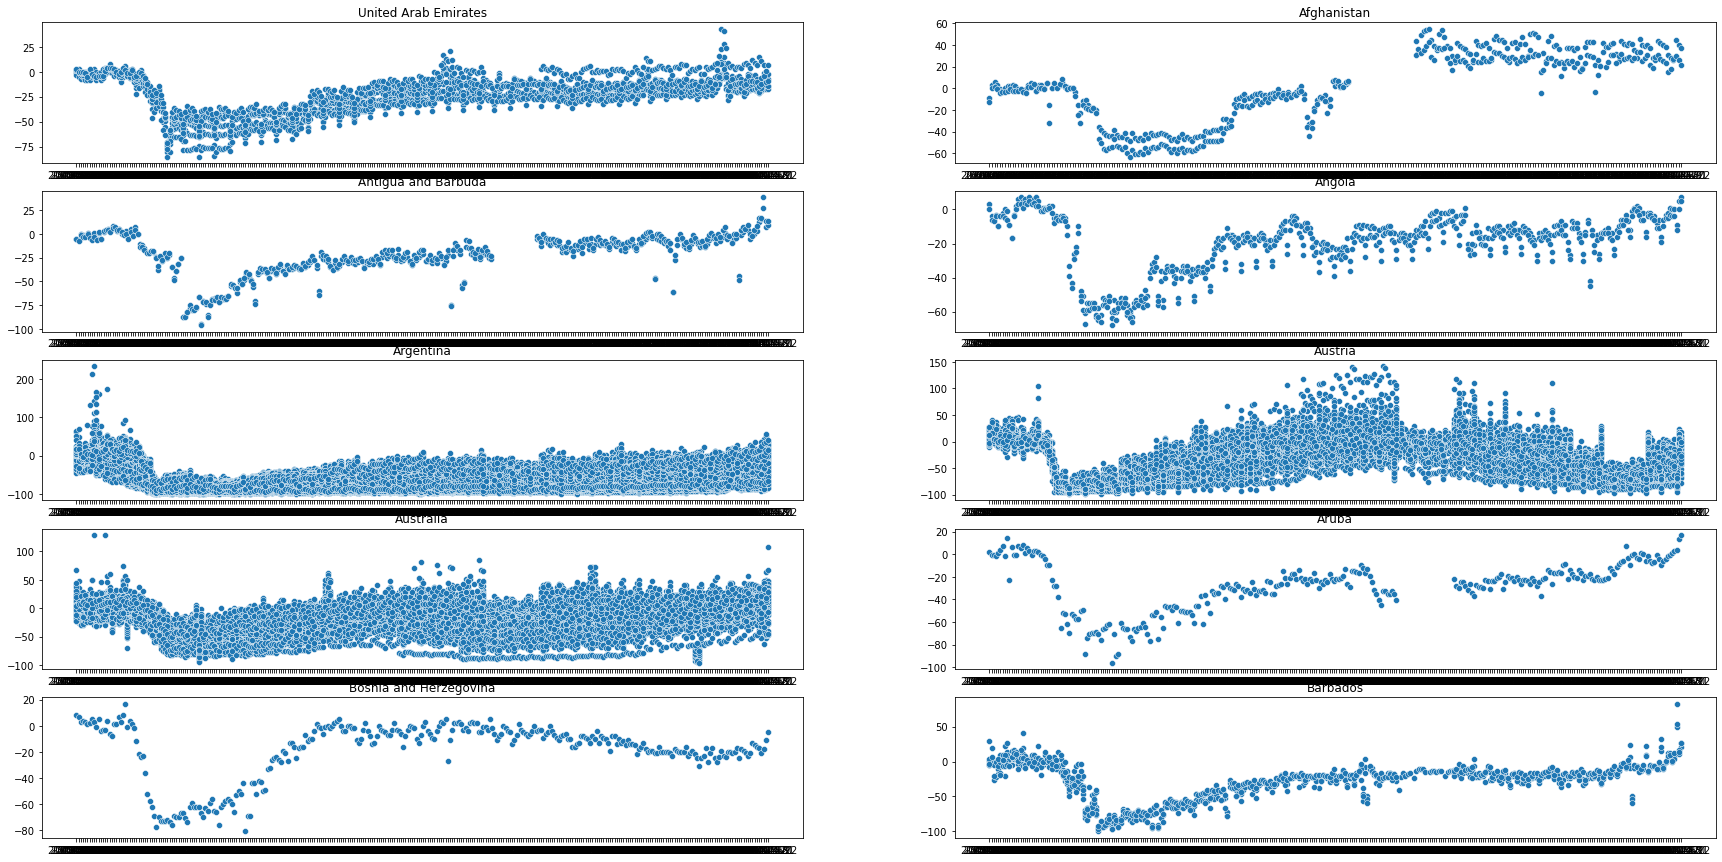

In [127]:
fig, axs = plt.subplots(5,2, figsize = (30,15))

ax_list = [item for sublist in axs for item in sublist]

for country in mob['country_region'].unique()[0:10]:
    ax = ax_list.pop(0)
    df_ = mob[mob['country_region'] == country]
    sns.scatterplot(x = 'date', y = 'retail_and_recreation_percent_change_from_baseline', data = df_, ax=ax)
    ax.set_title(country)
    ax.set_xlabel('')
    ax.set_ylabel('')

## 1.4. Testing data

In [128]:
cols = ['location', 'date', 'new_tests']
tests_df = pd.read_csv("owid-covid-data.csv")[cols]

In [129]:
tests_df = tests_df.fillna(-1) # to get where there is NA

tests_df['month'] = pd.to_datetime(tests_df.date).dt.month 
tests_df_agg = tests_df.groupby(['month', 'location']).agg({'new_tests': ['sum', 'min']}
                                                          ).reset_index().sort_values(['location', 'month'])

tests_df_agg = pd.concat([tests_df_agg[['month', 'location']], tests_df_agg['new_tests']], axis = 1)
tests_df_agg.columns = ['month', 'location', 'sum_new_tests', 'min_new_tests'] # Get where is NA by looking at where min_new_tests == -1

In [130]:
df3_agg = df2_agg.merge(tests_df_agg, how = 'left', left_on = ['country', 'month'], right_on = ['location', 'month'], validate='one_to_one').drop('location', axis = 1)
df3_agg

## 1.5. Governmental response

In [132]:
# Get total number of cases
sql_command = """
SELECT containment_health_index, date, country
FROM government_response

"""
gov_df = pd.read_sql(sql_command, conn)


In [134]:
def group_month(df, var, country_var='country'):
    df['month'] = pd.to_datetime(df.date).dt.month 
    df_agg = df.groupby(['month', country_var]).agg({var: 'mean'}).reset_index().sort_values(['country', 'month'])
    
    return df_agg

gov_df_agg = group_month(gov_df, 'containment_health_index')

df4_agg = df3_agg.merge(gov_df_agg, how = 'left', left_on = ['country', 'month'], right_on = ['country', 'month'], validate='one_to_one')

## 1.6. Regime Type

In [135]:
economist_df = pd.read_excel("The_Economist.xlsx")
economist_df = economist_df.loc[economist_df['time'] == 2019, ['name', 'Democracy index (EIU)']].copy()
economist_df.columns = ['country', 'democracy_index']
df5_agg = df4_agg.merge(economist_df, how = 'left', left_on = ['country'], right_on = ['country'], validate='many_to_one')

## 1.7. Distance from Wuhan

In [140]:
from opencage.geocoder import OpenCageGeocode
from geopy.distance import geodesic
from countryinfo import CountryInfo
import apikeys # Manual file
import pycountry_convert as pc

key = apikeys['key']  # Get the key
geocoder = OpenCageGeocode(key)

In [141]:
from functools import lru_cache

In [142]:
capitals = {'Slovakia': 'Bratislava',
 'Slovenia': 'Ljubljana',
 'South Africa': 'Cape Town',
 'South Korea': 'Seoul', 
 'Spain': 'Madrid',
 'Sweden': 'Stockholm',
 'Switzerland': 'Bern',
 'Tanzania': 'Dodoma',
 'Thailand': 'Bangkok',
 'Trinidad and Tobago': 'Port of Spain',
 'Turkey': 'Ankara',
 'Uganda': 'Kampala',
 'Ukraine': 'Kyiv', 
 'United Kingdom': 'London',
 'United States': 'Washington, D.C.',
 'Uruguay': 'Montevideo',
 'Venezuela': 'Caracas',
 'Vietnam': 'Hanoi',
 'Zambia': 'Lusaka',
 'Zimbabwe': 'Harare'}

In [143]:
capitals_2 = {
    'Andorra': 'Andorra la Vella',
    'Macedonia': 'Skopje',
    'Montenegro': 'Podgorica'
}

In [144]:
@lru_cache(maxsize=100)
def get_capital(country, capitals_2=capitals_2):
    
    if country in capitals_2.keys():
        return capitals_2[country]
    try:
    # Get the capital
        capital = CountryInfo(country).capital()
        return capital
    except:
        return None


In [146]:
df5_agg['capital'] = df5_agg['country'].map(get_capital)
df5_agg[df5_agg['capital'].map(lambda x: x is None)]['country'].unique()
lat_B, lng_B = geocoder.geocode('Wuhan')[0]['geometry'].values()

array([], dtype=object)

In [148]:
@lru_cache(maxsize=100)
def find_distance(city, lat_B=lat_B, lng_B=lng_B):
    
    result_A = geocoder.geocode(city)

    # Get lat, long
    lat_A, lng_A = result_A[0]['geometry'].values()
    
    return geodesic((lat_A,lng_A), (lat_B,lng_B)).km

In [149]:
df5_agg['distance'] = df5_agg['capital'].map(find_distance)

In [150]:
c_count(df5_agg)

Unique countries: 97


In [158]:
def get_continent(name):
    country_code = pc.country_name_to_country_alpha2(name, cn_name_format="default")
    continent_name = pc.country_alpha2_to_continent_code(country_code)
    return continent_name

def c_count(df):
    print("Unique countries:", df['country'].nunique())

df5_agg['continent'] = df5_agg.country.map(get_continent)
df5_agg['confirmed_log'] = np.log(df5_agg['confirmed'] + 0.0000000000001)

In [159]:
df5_agg.columns = [re.sub(r'[^\w]', '', x.replace(' ', '_')).lower() for x in df5_agg.columns] # Change col names
df5_agg.rename(columns={'current_health_expenditure__of_gdp': 'current_health_expenditure_of_gdp',
                       '65_and_above_by_population': 'over65_per_capita'}, inplace=True)
df5_agg.to_csv("2021-01-04 stats_dataset.csv", index=False)

# 2. COVID-19 and Individualism EDA

In [160]:
from scipy.stats import pearsonr

In [161]:
df = pd.read_csv("2021-01-04 stats_dataset.csv")

## 2.1. Getting COVID-19 data per month

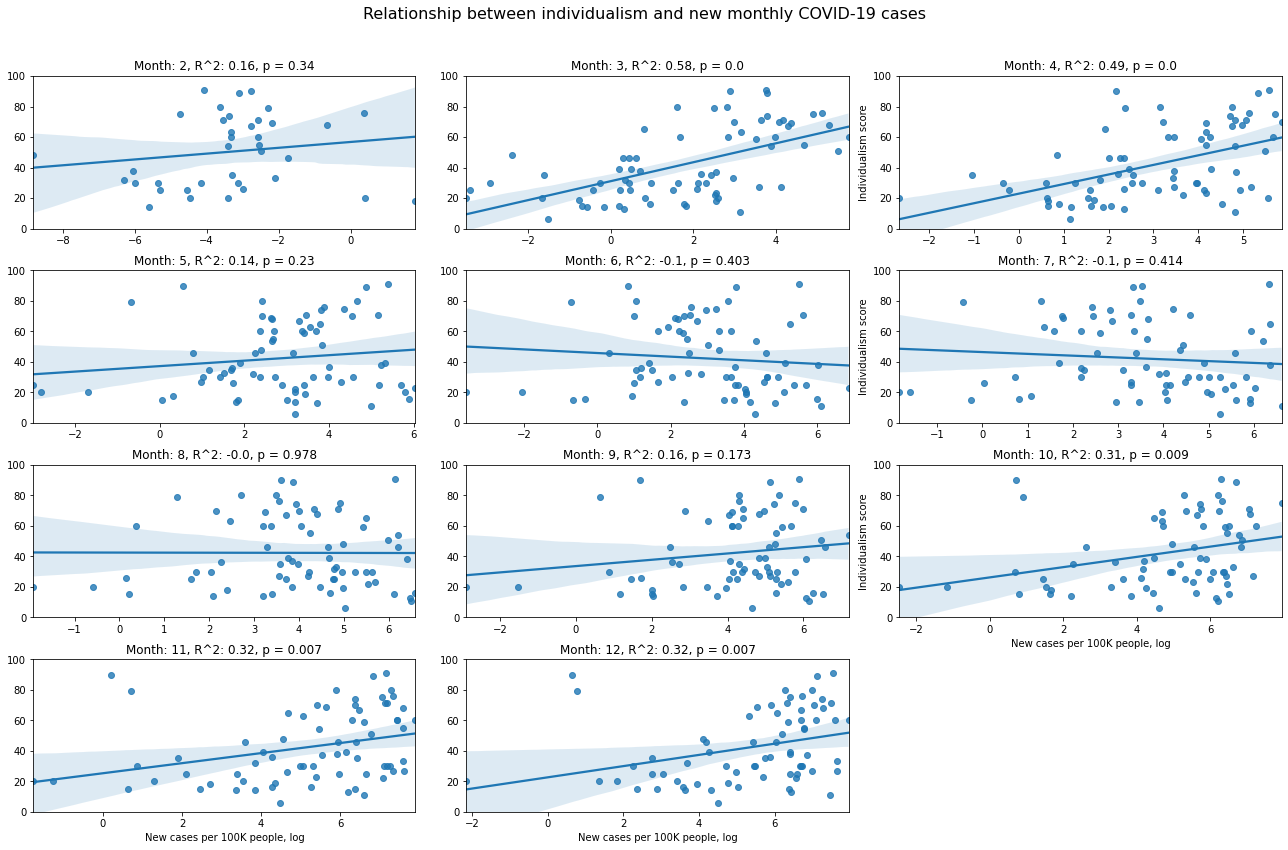

In [332]:
def get_individualism_scores(df=df, remove_last_plot=True):

    fig, axs = plt.subplots(4,3, figsize = (18,12))

    ax_list = [item for sublist in axs for item in sublist]

    for month in range(2,13):
        ax = ax_list.pop(0)
        df_ = df[df['month'] == month]
        df_ = df_[df_['new_cases_per_100k'] != 0]
        df_ = df_[df_['individualism_index'].notnull()]
        sns.regplot(x = 'new_cases_per_100k_log', y = 'individualism_index', data = df_, ax=ax)
        corr, p = pearsonr(df_['new_cases_per_100k_log'], df_['individualism_index'])
        ax.set_title(f"Month: {month}, R^2: {corr.round(2)}, p = {p.round(3)}")
        
        ax.set_ylim([0,100])

        # Set X labels
        if month in (1,4,7,10): ax.set_ylabel("Individualism score")
        else: ax.set_ylabel("")

        if month in (10,11,12): ax.set_xlabel("New cases per 100K people, log")
        else: ax.set_xlabel("")

    
    if remove_last_plot:
        fig.delaxes(axs[3,2])
    fig.suptitle("Relationship between individualism and new monthly COVID-19 cases", fontsize = 16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

get_individualism_scores()

<AxesSubplot:xlabel='new_cases_per_100k_log', ylabel='individualism_index'>

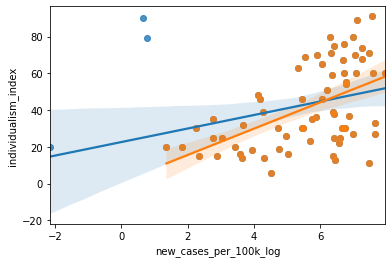

In [294]:
df_ = df[df['month'] == month]
df_ = df_[df_['new_cases_per_100k'] != 0]
df_ = df_[df_['individualism_index'].notnull()]
sns.regplot(x = 'new_cases_per_100k_log', y = 'individualism_index', data = df_)
sns.regplot(x = 'new_cases_per_100k_log', y = 'individualism_index', data = df_[~df_.country.isin(['Australia', 'New Zealand', 'Vietnam'])])

In [291]:
df_2 = df_[~df_.country.isin(['Australia', 'New Zealand', 'Vietnam'])].copy()
corr, p = pearsonr(df_2['new_cases_per_100k_log'], df_2['individualism_index'])

In [292]:
corr

0.5207701239060172

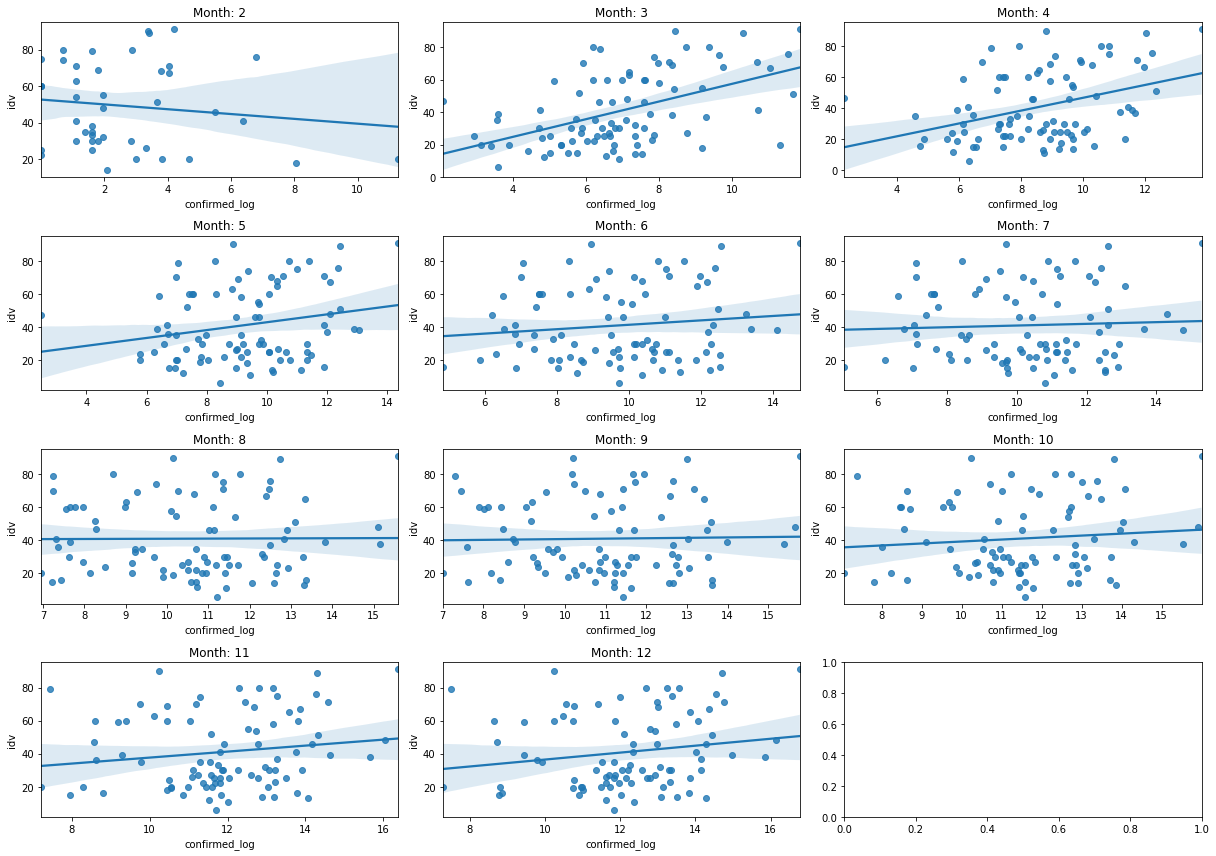

In [522]:
fig, axs = plt.subplots(4,3, figsize = (17,12))

ax_list = [item for sublist in axs for item in sublist]

for month in range(2,13):
    ax = ax_list.pop(0)
    df_ = df[df['month'] == month]
    df_ = df_[df_['new_cases_per_100k'] != 0]
    sns.regplot(x = 'confirmed_log', y = 'idv', data = df_, ax=ax)
    ax.set_title(f"Month: {month}")
    
plt.tight_layout()

## 2.2. Getting COVID-19 data by month for a number of countries

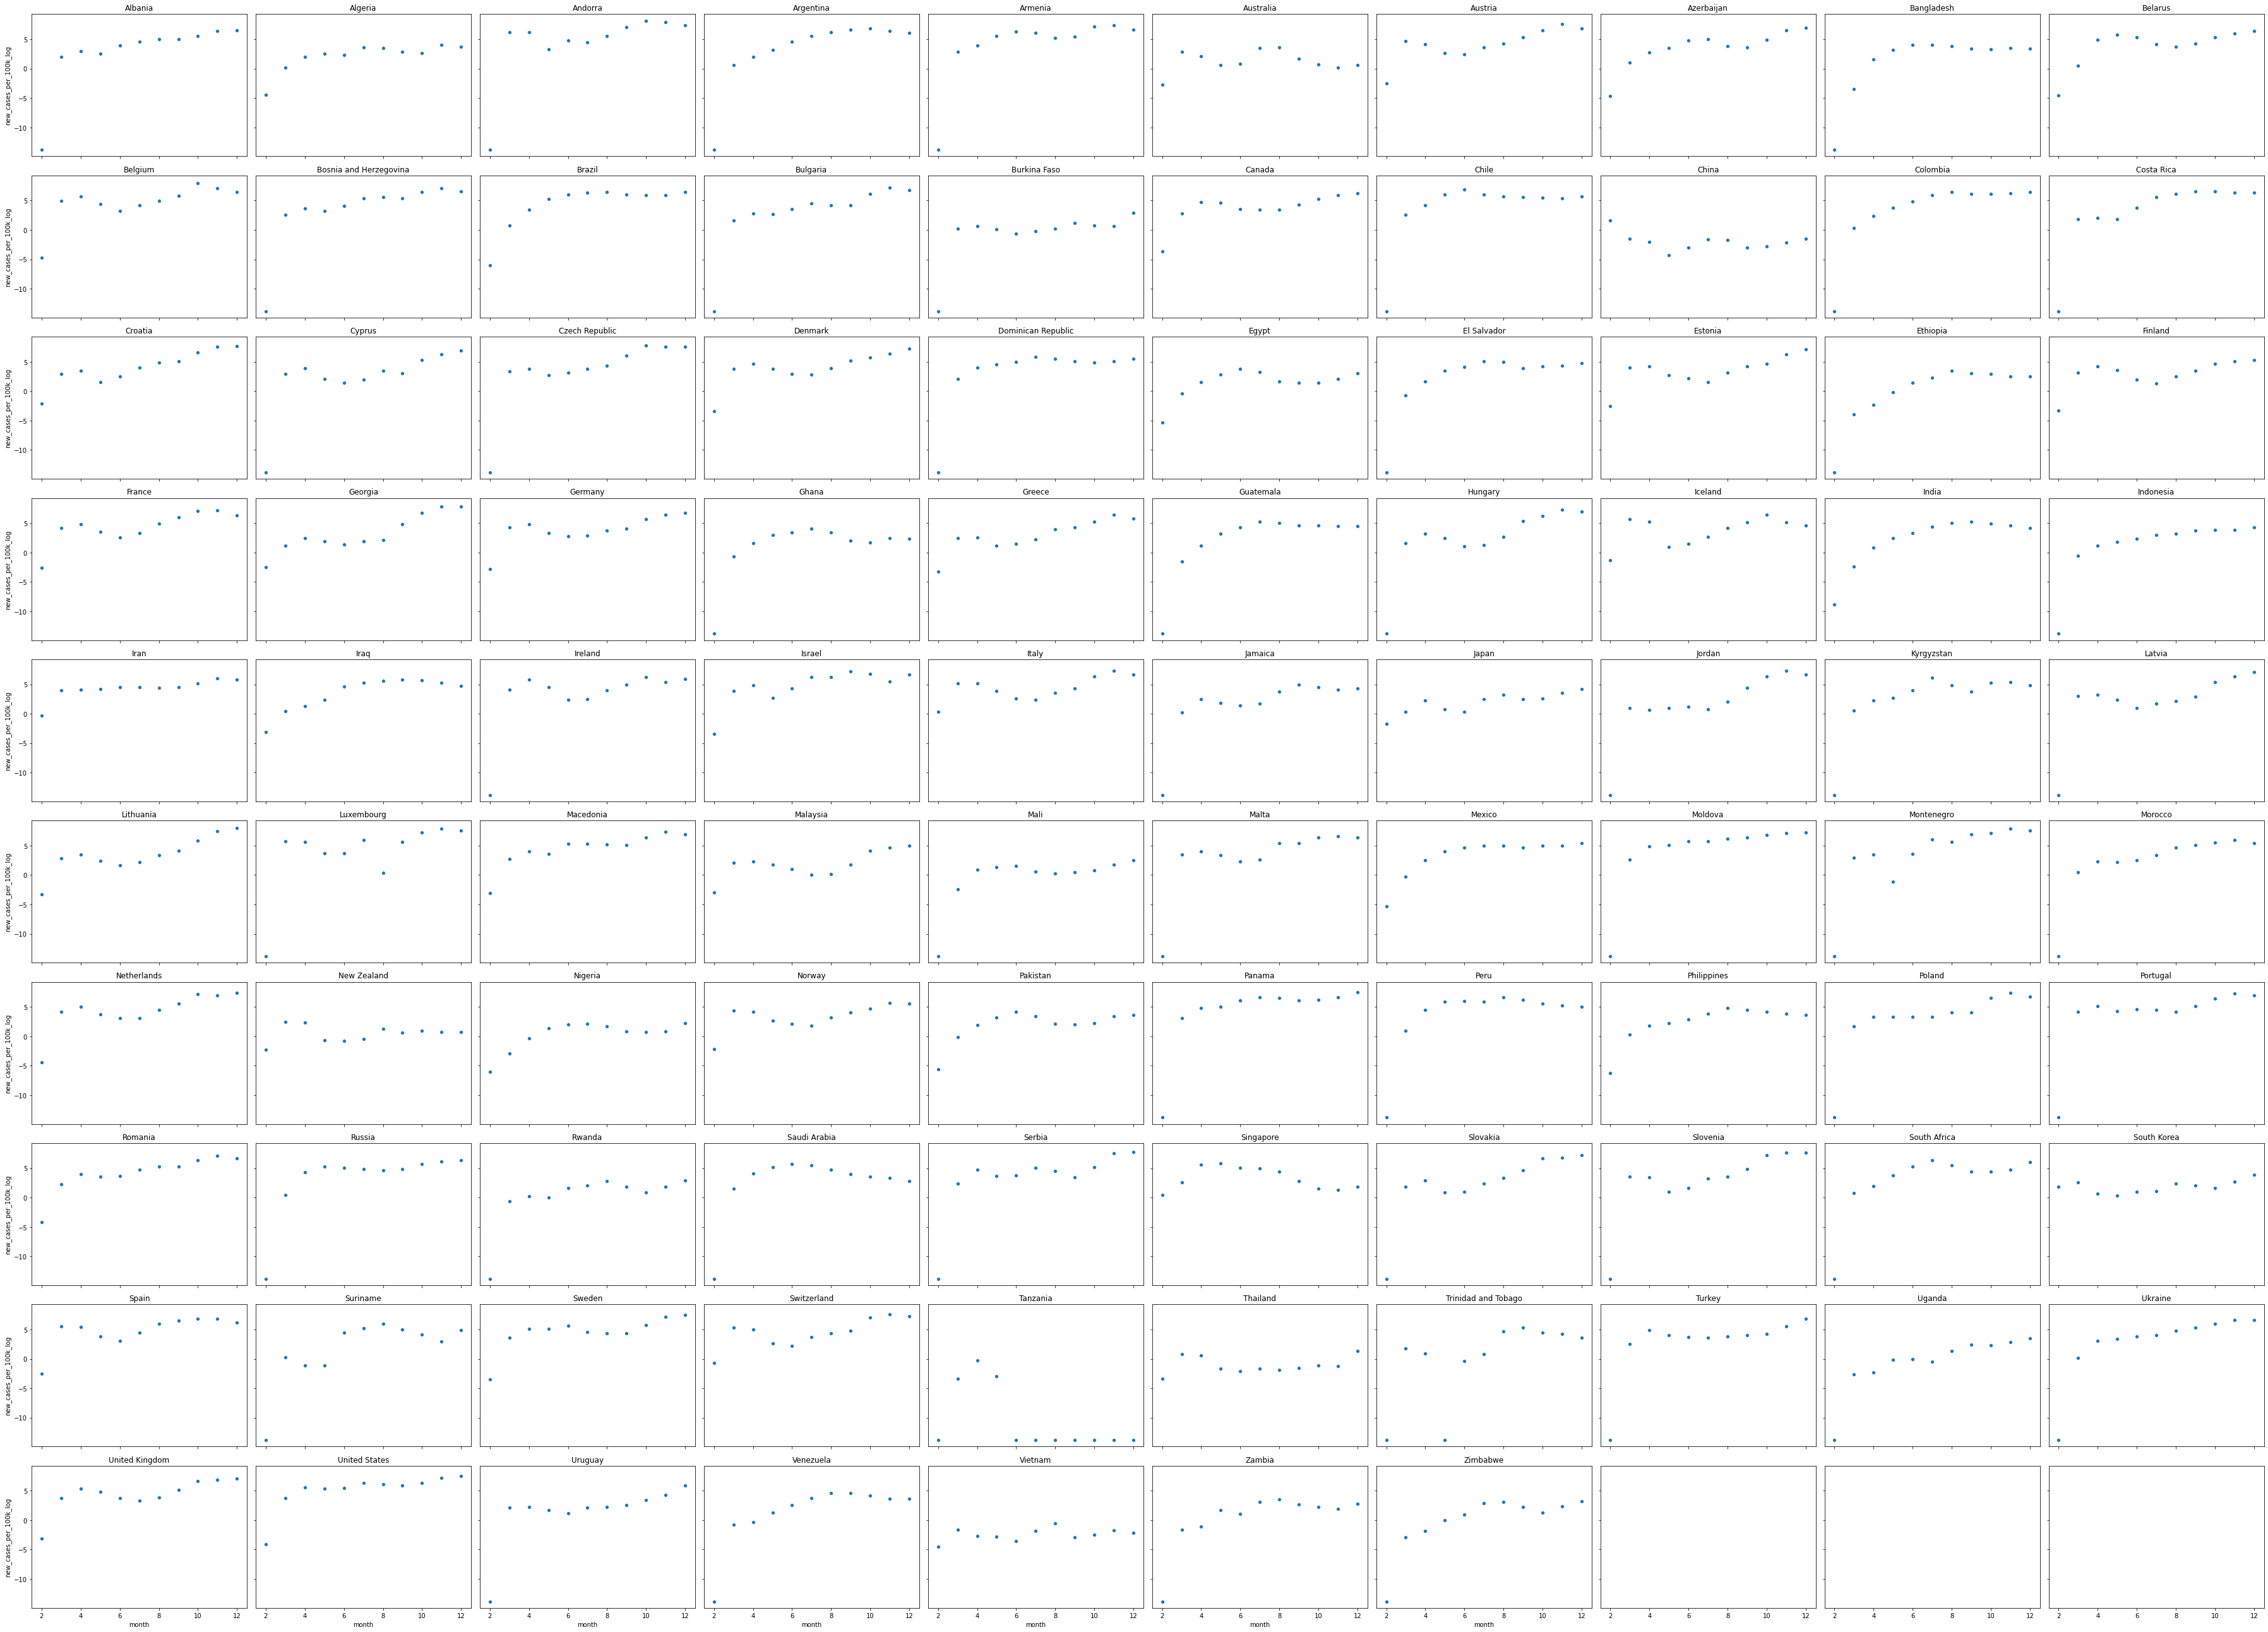

In [523]:
countries_unique = df['country'].unique()

fig, axs = plt.subplots(10,10, figsize=(5*10,4*9), sharex=True, sharey=True)
ax_list = [item for sublist in axs for item in sublist]

for country in countries_unique:
    ax = ax_list.pop(0)
    df_ = df[df['country'] == country]
    sns.scatterplot(x='month', y = 'new_cases_per_100k_log', data = df_, ax = ax)
    ax.set_title(country)

plt.tight_layout()


# 3. Cleaning the data

## 3.1. Dropping missing countries

In [164]:
drop_c = df.loc[df.idv.isnull(),'country'].unique()
print(f"Dropping {drop_c} countries due to missing values with the dependent variable")
df = df[~df['country'].isin(drop_c)].copy()

Dropping ['Andorra' 'Cyprus' 'Kyrgyzstan' 'Macedonia' 'Mali' 'Rwanda' 'Uganda'
 'Zimbabwe'] countries due to missing values with the dependent variable


In [165]:
c_count(df)

Unique countries: 89


In [166]:
null_cols = df.columns[~df.notnull().all()]

In [167]:
df[null_cols].isnull().sum()

current_health_expenditure_of_gdp                    22
passengers_carried_by_population                     88
gdp_per_capita_constant_2010_us                      22
population_density_people_per_sq_km_of_land_area     22
country_region                                      123
mobility_index                                      123
sum_new_tests                                        44
min_new_tests                                        44
containment_health_index                             23
democracy_index                                      11
continent                                           110
dtype: int64

In [168]:
for col in null_cols:
    countries = df.loc[df[col].isnull(),'country'].unique()
    print(f"Column: {col}. Countries missing: {countries}")


Column: current_health_expenditure_of_gdp. Countries missing: ['Albania' 'Montenegro']
Column: passengers_carried_by_population. Countries missing: ['Armenia' 'Bosnia and Herzegovina' 'Denmark' 'Dominican Republic'
 'Norway' 'Slovakia' 'Sweden' 'Uruguay']
Column: gdp_per_capita_constant_2010_us. Countries missing: ['Iran' 'Venezuela']
Column: population_density_people_per_sq_km_of_land_area. Countries missing: ['Georgia' 'Moldova']
Column: country_region. Countries missing: ['Albania' 'Algeria' 'Armenia' 'Azerbaijan' 'China' 'Czech Republic'
 'Ethiopia' 'Georgia' 'Iceland' 'Iran' 'Montenegro' 'Serbia' 'Suriname']
Column: mobility_index. Countries missing: ['Albania' 'Algeria' 'Armenia' 'Azerbaijan' 'China' 'Czech Republic'
 'Ethiopia' 'Georgia' 'Iceland' 'Iran' 'Montenegro' 'Serbia' 'Suriname']
Column: sum_new_tests. Countries missing: ['Albania' 'Armenia' 'Azerbaijan' 'Bangladesh' 'Bosnia and Herzegovina'
 'Bulgaria' 'Burkina Faso' 'Colombia' 'Costa Rica' 'Czech Republic'
 'Dominican 

In [169]:
countries_drop = ['Albania', 'Montenegro', 'Puerto Rico', 'Iran', 'Venezuela', 'Armenia', 'Montenegro', 'Netherlands', 'Slovakia']
df = df[~df.country.isin(countries_drop)].copy()

In [173]:
for col in null_cols:
    countries = df.loc[df[col].isnull(),'country'].unique()
    print(f"Column: {col}. Countries missing: {countries}")

Column: current_health_expenditure_of_gdp. Countries missing: []
Column: passengers_carried_by_population. Countries missing: ['Bosnia and Herzegovina' 'Denmark' 'Dominican Republic' 'Norway' 'Sweden'
 'Uruguay']
Column: gdp_per_capita_constant_2010_us. Countries missing: []
Column: population_density_people_per_sq_km_of_land_area. Countries missing: ['Georgia' 'Moldova']
Column: country_region. Countries missing: ['Algeria' 'Azerbaijan' 'China' 'Czech Republic' 'Ethiopia' 'Georgia'
 'Iceland' 'Serbia' 'Suriname']
Column: mobility_index. Countries missing: ['Algeria' 'Azerbaijan' 'China' 'Czech Republic' 'Ethiopia' 'Georgia'
 'Iceland' 'Serbia' 'Suriname']
Column: sum_new_tests. Countries missing: ['Azerbaijan' 'Bangladesh' 'Bosnia and Herzegovina' 'Bulgaria'
 'Burkina Faso' 'Colombia' 'Costa Rica' 'Czech Republic'
 'Dominican Republic' 'El Salvador' 'Ethiopia' 'Ghana' 'Hungary'
 'Indonesia' 'Jamaica' 'Jordan' 'Moldova' 'Panama' 'Peru' 'Poland'
 'Saudi Arabia' 'Slovenia' 'Suriname' 'Ta

In [174]:
exclude_cols = ['sum_new_tests', 'min_new_tests', 'passengers_carried_by_population', 'country_region']
df = df.drop(exclude_cols, axis = 1).copy()

In [176]:
df['continent'].isnull().sum()

110

In [178]:
df['continent'] = df['continent'].map(lambda x: 'N.A.' if pd.isnull(x)  else 'SA' if x == 'Trinidad and Tobago' else x)
for col in df.columns[~df.notnull().all()]:
    countries = df.loc[df[col].isnull(),'country'].unique()
    print(f"Column: {col}. Countries missing: {countries}")


Column: population_density_people_per_sq_km_of_land_area. Countries missing: ['Georgia' 'Moldova']
Column: mobility_index. Countries missing: ['Algeria' 'Azerbaijan' 'China' 'Czech Republic' 'Ethiopia' 'Georgia'
 'Iceland' 'Serbia' 'Suriname']


In [179]:
df = df[~df.country.isin(['Moldova', 'Georgia'])].copy()

In [180]:
for col in df.columns[~df.notnull().all()]:
    countries = df.loc[df[col].isnull(),'country'].unique()
    print(f"Column: {col}. Countries missing: {countries}")


Column: mobility_index. Countries missing: ['Algeria' 'Azerbaijan' 'China' 'Czech Republic' 'Ethiopia' 'Iceland'
 'Serbia' 'Suriname']


In [181]:
drop_countries = ['Algeria', 'Azerbaijan', 'China', 'Czech Republic', 'Ethiopia', 'Iceland', 'Serbia', 'Suriname']
df = df[~df.country.isin(drop_countries)].copy()

In [182]:
for col in df.columns[~df.notnull().all()]:
    countries = df.loc[df[col].isnull(),'country'].unique()
    print(f"Column: {col}. Countries missing: {countries}")


## 3.2. Calculating the number of cases for neighboring countries that month

In [187]:
from countryinfo import CountryInfo
import pycountry


In [188]:
cases_df = get_cases(conn)
cases_df = calculate_capita_metrics(cases_df)
cases_df = get_daily_growth(cases_df) 
cases_df = daily_growth_check(cases_df, drop_countries = True)

A total of 30 entries are excluded from the initial dataset since they do not have data for Population.
These are: Mayotte, Other continent, Saint Helena, Oceania, Pitcairn Islands, Martinique, Reunion, Wallis and Futuna, Guernsey, Montserrat, Cook Islands, Kosovo, Asia, French Guiana, Bonaire, Sint Eustatius and Saba, Tokelau, Saint-Barthélemy, America, Saint Pierre and Miquelon, Falkland Islands, Taiwan, Niue, Anguilla, World, Guadeloupe, Africa, Western Sahara, Vatican City, Europe, Jersey

There are 64 cases of negative daily growth in cases from the data

Dropped 4 countries from further analysis: Benin, Ecuador, Puerto Rico, São Tomé and Príncipe.



In [189]:
def get_month_agg(df):
    df['month'] = pd.to_datetime(df.date).dt.month
    df1_agg = df.groupby(['country', 'month']).agg({
                                            'confirmed': 'max', # latest # of cumulative cases each month
                                            'new_cases_per_100K': 'sum'}).reset_index() 
    
    return df1_agg

In [190]:
cases_df = get_month_agg(cases_df)

In [192]:
def get_neighbors_all(df):
        
    countries_correct = {'Albania': ['MNE', 'GRC', 'MKD'],
                         'Serbia': ['HUN', 'ROU', 'BGR', 'MKD', 'HRV', 'BIH', 'MNE', 'ALB'],
                         'South Korea': []}
    
    change_names = {'Russian Federation': 'Russia',
                    'Iran, Islamic Republic of': 'Iran',
                    'Bolivia, Plurinational State of': 'Bolivia',
                    'Czechia': 'Czech Republic',
                    'Tanzania, United Republic of': 'Tanzania',
                     'Viet Nam': 'Vietnam'
                    }
    for country in df.country.unique():

        print(f"Country: {country}")
        # Get neighbors (short names)
        try:
            countries_short = CountryInfo(country).borders()
        except KeyError:
            print(f"Passing country {country}")
            continue
        
        # Add corrections due to package problems
        if country in countries_correct.keys():
            countries_short = countries_correct[country]
            

        # Get full list of countries
        get_name = lambda x: pycountry.countries.get(alpha_3=x).name
        bordering_countries = list(map(get_name, countries_short))
        bordering_countries = [change_names[x] if x in change_names.keys() else x for x in bordering_countries]

            # Get country average cases for the country
        unique_after = df[df.country.isin(bordering_countries)].country.unique()

        if len(unique_after) != len(bordering_countries):
            set_diff = set(bordering_countries).difference(set(unique_after))
            print(f"Country {country} missing: {set_diff}")
        
        country_avg_cases = df.loc[df.country.isin(bordering_countries)].groupby(['month']).new_cases_per_100K.mean().reset_index()
        

        # Check if there are any borders
        if len(bordering_countries) == 0:
            continue

        # Get country average cases for the country
        country_avg_cases = df.loc[df.country.isin(bordering_countries)].groupby(['month']).new_cases_per_100K.mean().reset_index()

        # Get the indices for the main country (required to assign series to df)
        indices = df.loc[(df.country == country)].index
        values_to_set = country_avg_cases.set_index(indices)['new_cases_per_100K']

        # Set the dataframe values
        df.loc[(df.country == country), 'cases_neighbors'] = values_to_set
        
    return df

In [193]:
cases_df = get_neighbors_all(cases_df)

Country: Afghanistan
Country: Albania
Country Albania missing: {'North Macedonia'}
Country: Algeria
Country Algeria missing: {'Western Sahara'}
Country: American Samoa
Country: Andorra
Passing country Andorra
Country: Angola
Country Angola missing: {'Congo, The Democratic Republic of the', 'Namibia', 'Congo'}
Country: Antigua and Barbuda
Country: Argentina
Country: Armenia
Country: Aruba
Country: Australia
Country: Austria
Country: Azerbaijan
Country: Bahamas
Passing country Bahamas
Country: Bahrain
Country: Bangladesh
Country: Barbados
Country: Belarus
Country: Belgium
Country: Belize
Country: Bermuda
Country: Bhutan
Country: Bolivia
Country: Bosnia and Herzegovina
Country: Botswana
Country Botswana missing: {'Namibia'}
Country: Brazil
Country Brazil missing: {'French Guiana', 'Venezuela, Bolivarian Republic of'}
Country: British Virgin Islands
Passing country British Virgin Islands
Country: Brunei
Country: Bulgaria
Country Bulgaria missing: {'North Macedonia'}
Country: Burkina Faso
C

In [194]:
cases_df[cases_df.country.isin(['Russia', 'Belarus', 'Latvia', 'Poland']) & (cases_df.month == 6)]['new_cases_per_100K'].mean()

102.71813229329884

In [30]:
cases_df[cases_df.country == 'Lithuania']

country  month  confirmed  new_cases_per_100K  cases_neighbors
1248  Lithuania      1     146637          217.378511        81.953512
1249  Lithuania      2          1            0.035883         0.002641
1250  Lithuania      3        484           17.331433         7.070394
1251  Lithuania      4       1449           31.971650        65.594832
1252  Lithuania      5       1670           10.585451       137.057066
1253  Lithuania      6       1816            5.238901       102.718132
1254  Lithuania      7       2062            8.827189        57.774407
1255  Lithuania      8       2874           29.136902        53.677582
1256  Lithuania      9       4578           61.144434        68.289774
1257  Lithuania     10      13823          331.737263       344.114493
1258  Lithuania     11      61325         1704.508756       788.182962
1259  Lithuania     12     140579         2843.862089       793.408555

In [195]:
df = pd.merge(df, cases_df[['country', 'month', 'cases_neighbors']], left_on = ['country', 'month'], right_on = ['country', 'month'], how = 'left')

In [196]:
countries_no_neighbors = df[df.cases_neighbors.isnull()]['country'].unique()
print(countries_no_neighbors)

['Australia' 'Jamaica' 'Japan' 'Malta' 'New Zealand' 'Philippines'
 'Singapore' 'South Korea' 'Trinidad and Tobago']


These countries don't have the metric, so take the continent average

In [198]:
continent_avgs = df.groupby(['continent', 'month']).new_cases_per_100k.mean().reset_index()

In [199]:
for c in countries_no_neighbors:
    continent = df.loc[df.country == c, 'continent'].iloc[0]
    ind = df.loc[df.country == c, 'cases_neighbors'].index
    set_values = continent_avgs.loc[continent_avgs.continent == continent, ['new_cases_per_100k']].set_index(ind)
    df.loc[df.country == c, 'cases_neighbors'] = set_values['new_cases_per_100k']

In [200]:
countries_no_neighbors_updated = df[df.cases_neighbors.isnull()]['country'].unique()
print(countries_no_neighbors_updated)

[]


## 3.3. Changing variable names, adding interaction

In [202]:
df.rename(columns={'idv': 'individualism_index',
                   'current_health_expenditure_of_gdp' :'health_expenditure',
                   'gdp_per_capita_constant_2010_us': 'gdp_per_capita',
                   'population_density_people_per_sq_km_of_land_area': 'population_density', 
                   }, inplace = True)

In [208]:
for col in ['health_expenditure', 'distance', 'gdp_per_capita']:
    df[col+'_log'] = np.log(df[col])

In [87]:
# Adding new changes to the model
def get_interactions(df, month_12=False):
    if month_12:
        df['individualism_gov'] = df['individualism_index'] * df['containment_health_index_avg']
        df['individualism_mob'] = df['individualism_index'] * df['mobility_index_avg']
    else:
        df['individualism_gov'] = df['individualism_index'] * df['containment_health_index']
        df['individualism_mob'] = df['individualism_index'] * df['mobility_index']
    return df

df = get_interactions(df)

In [309]:
df['cases_neighbors_lag'] = df['cases_neighbors'].shift(1)
df.loc[df.month == 2, 'cases_neighbors_lag'] = 0

In [212]:
df.to_csv("2021-01-04 final_data.csv", index=False)

In [2]:
df = pd.read_csv('2021-01-04 final_data.csv')

In [3]:
df['country'].nunique()

72

# 4. Results section for the paper

## 4.1. General table

In [585]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 'continent',  'individualism_gov',
              'cases_neighbors']
df2 = df[vars_to_use]
df2.columns = ['ind', 'gdp', 'popdens', 'mob', 'containm', 'dem', 'dist', 'cont', 'ind_gov', 'neighb']

In [586]:
with open('summary_table.tex','w') as tf:
    tf.write(df2.describe().round(2).to_latex())

In [372]:
df2.columns = [f'X_{n}' for n in range(1,11)]

## 4.2. Individualism scores

### 4.2.1. Overall individualism

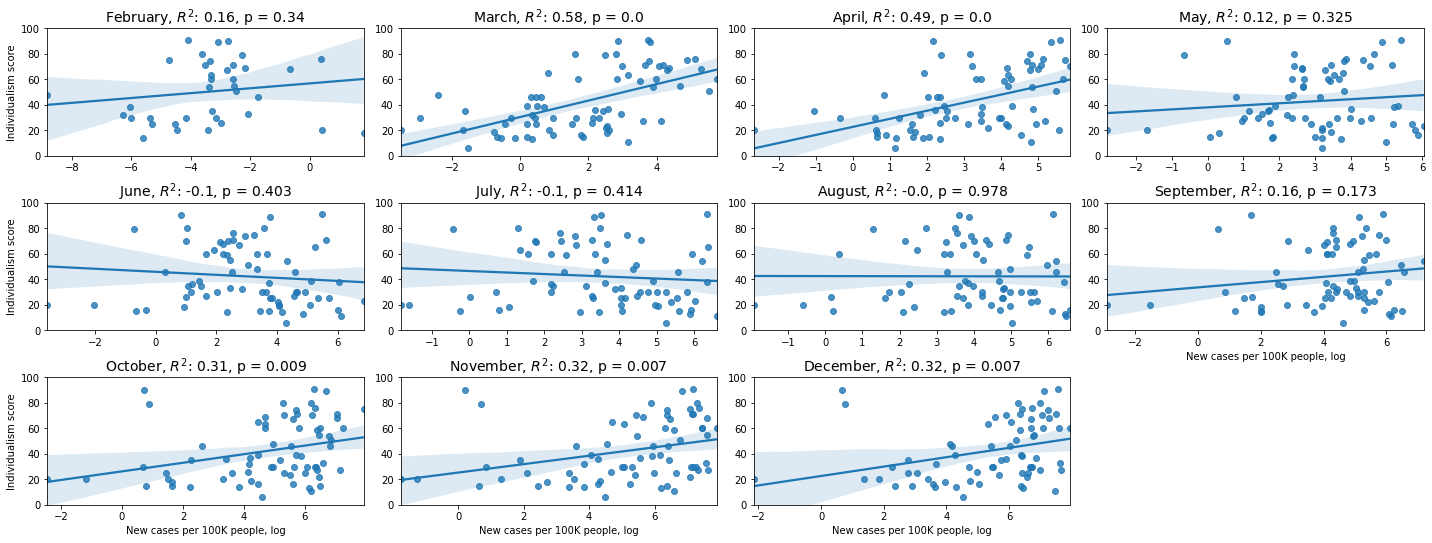

In [90]:
def get_individualism_scores(df=df, remove_last_plot=True, export_to_png=False, title=True):

    fig, axs = plt.subplots(3,4, figsize = (20,8))

    ax_list = [item for sublist in axs for item in sublist]

    for month in range(2,13):
        ax = ax_list.pop(0)
        df_ = df[df['month'] == month]
        df_ = df_[df_['new_cases_per_100k'] != 0]
        df_ = df_[df_['individualism_index'].notnull()]
        sns.regplot(x = 'new_cases_per_100k_log', y = 'individualism_index', data = df_, ax=ax)
        corr, p = pearsonr(df_['new_cases_per_100k_log'], df_['individualism_index'])
        ax.set_title(f"{calendar.month_name[month]}, $R^2$: {corr.round(2)}, p = {p.round(3)}", fontsize = 14)
        
        ax.set_ylim([0,100])

        # Set X labels
        if month in (2,6,10): ax.set_ylabel("Individualism score")
        else: ax.set_ylabel("")

        if month in (9,10,11,12): ax.set_xlabel("New cases per 100K people, log")
        else: ax.set_xlabel("")

    
    if remove_last_plot:
        fig.delaxes(axs[2,3])
    
    if title:
        fig.suptitle("Relationship between individualism and new monthly COVID-19 cases", fontsize = 24)
   
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    if export_to_png:
        fig.savefig('Individualism_newcases4.png')

get_individualism_scores(export_to_png=True, title=False)

In [91]:
df.columns

Index(['country', 'month', 'individualism_index', 'confirmed', 'dead',
       'population', 'health_expenditure', 'gdp_per_capita',
       'population_ages_65_and_above_total', 'population_density',
       'over65_per_capita', 'population_total', 'new_cases_per_100k',
       'new_cases_total', 'new_deaths_total', 'new_cases_total_log',
       'new_cases_per_100k_log', 'new_deaths_total_log', 'mobility_index',
       'containment_health_index', 'democracy_index', 'capital', 'distance',
       'continent', 'confirmed_log', 'cases_neighbors', 'distance_log',
       'individualism_gov', 'individualism_mob', 'health_expenditure_log',
       'gdp_per_capita_log', 'gdp'],
      dtype='object')

0.31727538808414757 0.0070178711833126855
0.5207701239060172 5.298551251561445e-06


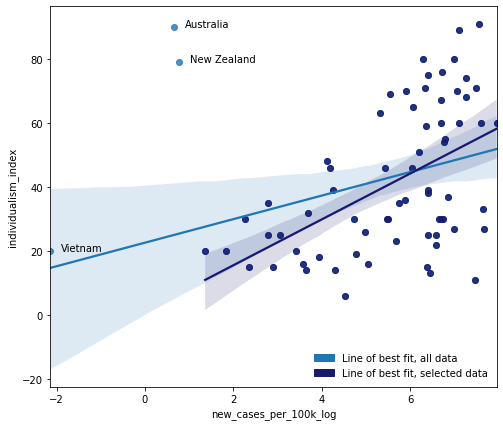

In [113]:
month = 12
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if point['val'] in ['Australia', 'New Zealand', 'Vietnam']:
            ax.text(point['x']+.25, point['y'], str(point['val']))


fig, ax = plt.subplots(1,1,figsize=(8,7))
df_ = df[df['month'] == month]
df_ = df_[df_['new_cases_per_100k'] != 0]
df_ = df_[df_['individualism_index'].notnull()]
df_2 = df_[~df_.country.isin(['Australia', 'New Zealand', 'Vietnam'])]

f1 = sns.regplot(x = 'new_cases_per_100k_log', y = 'individualism_index', data = df_, ax=ax)
f2 = sns.regplot(x = 'new_cases_per_100k_log', y = 'individualism_index', data = df_2, ax=ax, 
           scatter_kws = {'color': 'midnightblue'}, line_kws = {'color': 'midnightblue'})
corr, p = pearsonr(df_['new_cases_per_100k_log'], df_['individualism_index'])
print(corr,p)
corr2, p2 = pearsonr(df_2['new_cases_per_100k_log'], df_2['individualism_index'])
print(corr2,p2)


#ax.set_title(f"{calendar.month_name[month]}, $R^2$: {corr.round(2)}, p = {p.round(3)}")

blue_patch = mpatches.Patch(color='tab:blue', label='Line of best fit, all data')
midnight_patch = mpatches.Patch(color='midnightblue', label='Line of best fit, selected data')

#plt.legend(handles=[red_patch, midnight_patch], bbox_to_anchor = (1.01, 1), loc = 'upper left', frameon=True)
plt.legend(handles=[blue_patch, midnight_patch], loc = 'lower right', frameon=False)

label_point(df_.new_cases_per_100k_log, df_.individualism_index, df_.country, plt.gca())

fig.savefig('month_12.png')

### 4.2.2. Cumulative individualism

In [135]:
df['confirmed_per_100k'] = (df['confirmed'] / df['population']) * 100_000
df['confirmed_per_100k_log'] = np.log(df['confirmed_per_100k'] + 0.0000000000001)

In [141]:
def get_individualism_scores(df=df, remove_last_plot=True, export_to_png=False, title=True, cumulative=False):
    if cumulative: individualism='confirmed_per_100k_log'
    else: individualism = 'new_cases_per_100k_log'

    fig, axs = plt.subplots(3,4, figsize = (20,8))

    ax_list = [item for sublist in axs for item in sublist]

    for month in range(2,13):
        ax = ax_list.pop(0)
        df_ = df[df['month'] == month]
        
        df_ = df_[df_['new_cases_per_100k'] != 0]
        df_ = df_[df_['individualism_index'].notnull()]
        sns.regplot(x = individualism, y = 'individualism_index', data = df_, ax=ax)
        corr, p = pearsonr(df_[individualism], df_['individualism_index'])
        ax.set_title(f"{calendar.month_name[month]}, $R^2$: {corr.round(2)}, p = {p.round(3)}")
        
        ax.set_ylim([0,100])

        # Set X labels
        if month in (2,6,10): ax.set_ylabel("Individualism score")
        else: ax.set_ylabel("")
        
        if not cumulative:
            if month in (10,11,12): ax.set_xlabel("New cases per 100K people, log")
            else: ax.set_xlabel("")
        else:
            if month in (9,10,11,12): ax.set_xlabel("Cumulative cases per 100K people, log")
            else: ax.set_xlabel("")
    
    if remove_last_plot:
        fig.delaxes(axs[2,3])
    
    if not cumulative:
        if title:
            fig.suptitle("Relationship between individualism and new monthly COVID-19 cases", fontsize = 16)
   
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    if not cumulative:
        if export_to_png:
            fig.savefig('Individualism_newcases3.png')
    else:     
        if export_to_png:
            fig.savefig('Individualism_cumulativecases3.png')

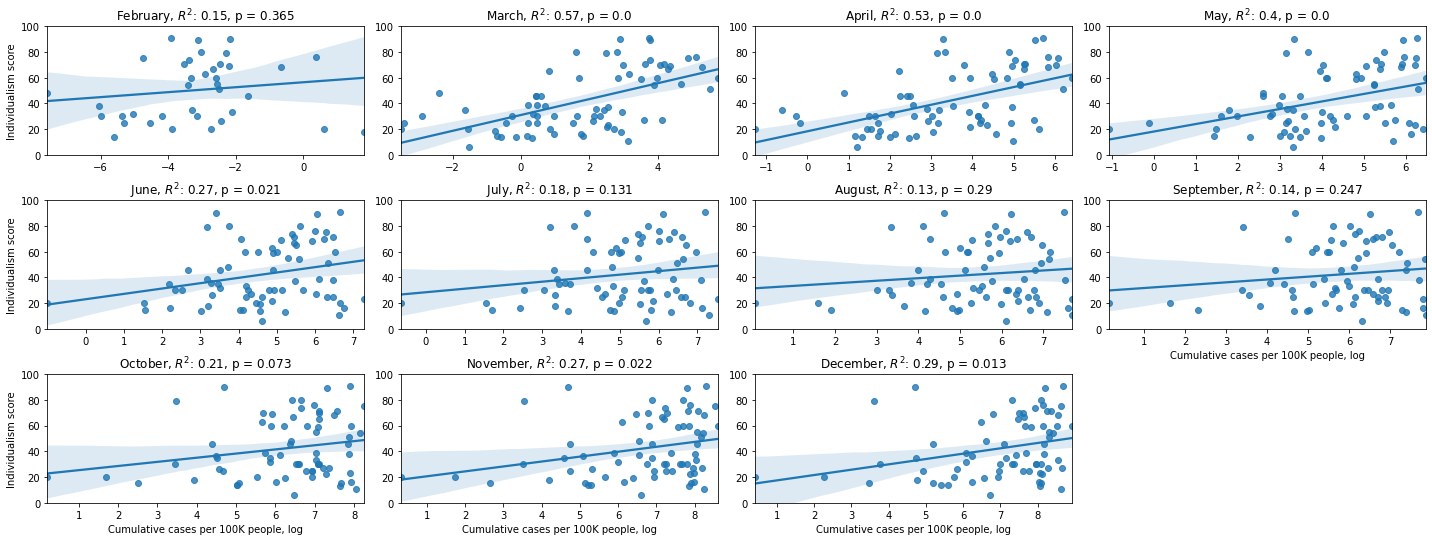

In [143]:
get_individualism_scores(title=False, cumulative=True, export_to_png=True)

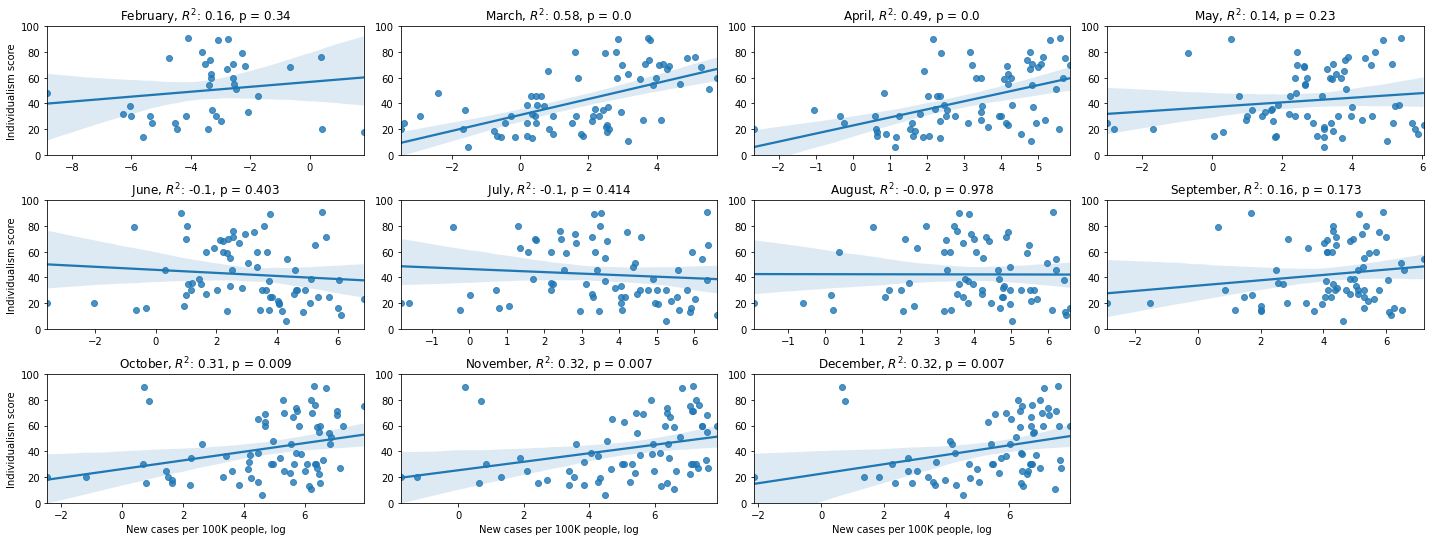

In [144]:
get_individualism_scores(title=False, cumulative=False, export_to_png=True)

### 4.2.3. Relationship between all variables

In [167]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 'continent',  'individualism_gov',
              'cases_neighbors']

In [168]:
#sns.regplot(x=vars_to_use, y='individualism_index', data=df_newest)

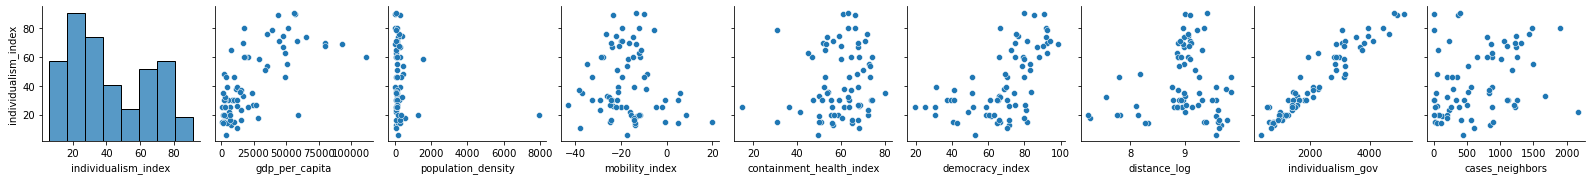

In [162]:
sns.pairplot(df_newest[vars_to_use], y_vars='individualism_index')

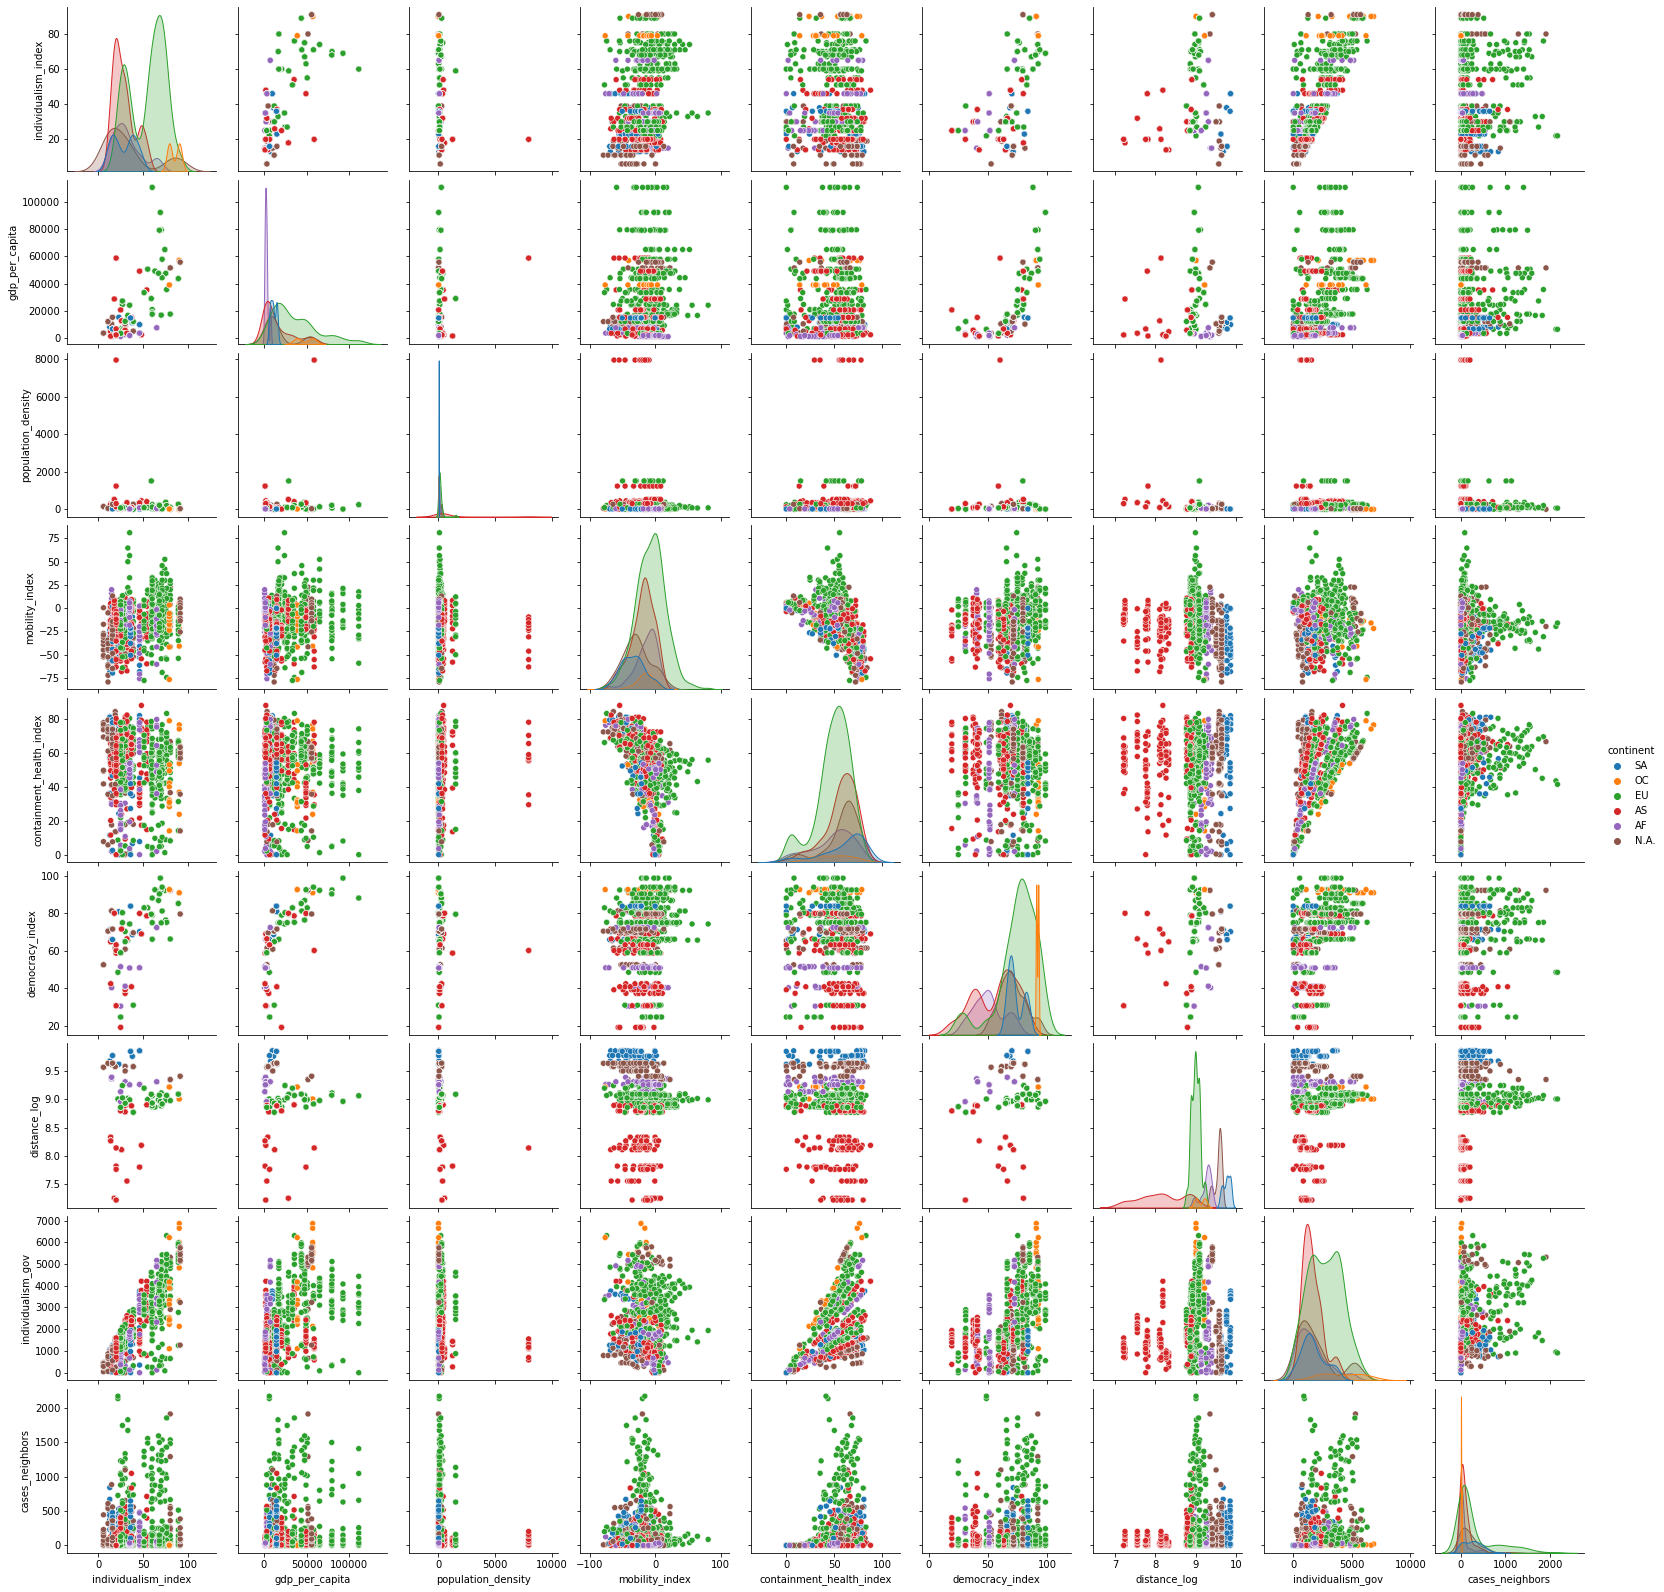

In [151]:
sns.pairplot(df[vars_to_use], hue = 'continent')

### 4.2.4. Relationship between government intervention and invidualism

In [2]:
# Establish connection

conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19')
cur = conn.cursor()

In [80]:
def get_gov_data(threshold=0.8):
    """Extract governmental data from the postgres database and checks for high similarities between entries
    
    Args:
        threshold (float): the threshold for deciding whether strings are similar
        
    Returns:
        gov_df (dataframe): dataframe containing government response information
    """

    # Extract the data
    sql_command = """
    SELECT date, country,c6_Stay_at_home_requirements,  c6_Flag
    FROM government_response
    WHERE source = 'GOVTRACK'
    """
    gov_df = pd.read_sql(sql_command, conn)
    gov_df['date'] = pd.to_datetime(gov_df['date'])
    
    # Inspect countries for similarities (to try to find duplicate entries)
    countries_lower = [c.lower() for c in gov_df['country'].unique()]
    
    print("Countries with similar strings: ")
    for c1, c2 in itertools.combinations(countries_lower, 2):
        if SequenceMatcher(None, c1, c2).ratio() > threshold:
            print(f"Country 1: {c1} Country 2: {c2}")
            
    return gov_df


def get_stay_at_home_metrics(gov_df):
    """Add additional stay-at-home metrics to the dataframe

    The function finds the first time a government imposed stay at home requirements
    on a national scale that are at least 2 or 3 in strength, as measured by the
    C6 index on the OXCOVID-19 database. Local restrictions are not taken into account.
    
    The function calculates:
    - the number of days before and after the introduced requirements for each day and country
    - the number of weeks before and after the introduced requirements for each day and country
    
    The weeks are calculated on a daily basis as opposed to taking calendar weeks. For example,
    the first 7 days after the introduction of the requirements are considered week 1, regardless
    of the day of the week. Note that this calculation does not take into account if a government
    uplifted its requirements.
    
    Args:
        gov_df (dataframe): Dataframe containing government response information
        
    Returns:
        gov_df (dataframe): New dataframe that includes additional columns on government response
    """
    
    # Get countries with stay at home requirements on a national level
    countries_with_req = gov_df.loc[(gov_df['c6_stay_at_home_requirements'].isin([2,3])), 'country'].unique()
    gov_df = gov_df[gov_df['country'].isin(countries_with_req)].copy()
    gov_df.sort_values(['country', 'date'], inplace = True)
    gov_df.index = pd.RangeIndex(len(gov_df))
    
    # Loop over all the countries
    for country in countries_with_req:
        
        # Filter country specific values
        gov_filter = gov_df.country == country        
        first_country_filter = gov_df.loc[gov_filter].index.min()
        
        # Get the id of stay at home requirements
        home_id_any_level = gov_df.loc[gov_filter, 'c6_stay_at_home_requirements'].isin([2,3]).idxmax()
        #c5_flag = (gov_df.loc[gov_filter, 'c6_flag'] == 1).idxmax()
        home_id = home_id_any_level

        # Get days before and after filters
        days_before_filter = gov_df.index < home_id
        days_after_filter = gov_df.index >= home_id

        # Assign the number of days before and after for each country
        gov_df.loc[gov_filter & days_before_filter, 'days_after'] = range(first_country_filter-home_id, 0, 1)
        gov_df.loc[gov_filter & days_after_filter, 'days_after'] = range(0, np.sum(gov_filter & days_after_filter))
        gov_df.loc[gov_filter, 'weeks_after'] = gov_df.loc[gov_filter, 'days_after'].map(
            lambda day: math.ceil(day/7) if day > 0 else math.floor(day/7))
        
  
    return gov_df


gov_df = get_gov_data()

# Excluding "Viet nam" since it is entered two times
gov_df = gov_df[gov_df['country'] != 'Viet Nam']

# Extracting additional metrics for plotting
gov_df = get_stay_at_home_metrics(gov_df)

Countries with similar strings: 
Country 1: iceland Country 2: ireland
Country 1: australia Country 2: austria
Country 1: vietnam Country 2: viet nam
Country 1: niger Country 2: nigeria
Country 1: gambia Country 2: zambia


In [81]:
gov_df[gov_df.country == 'United States'].sort_values('date')

Empty DataFrame
Columns: [date, country, c6_stay_at_home_requirements, c6_flag, days_after, weeks_after]
Index: []

In [82]:
gov_df[gov_df.country == 'United States']['c6_stay_at_home_requirements'].max()

nan

In [87]:
df2 = pd.read_excel("6-dimensions-for-website-2015-08-16.xls")

In [89]:
df2 = df2[['country', 'idv']]

In [90]:
df2.head()

country   idv
0  Africa East  27.0
1  Africa West  20.0
2      Albania  20.0
3      Algeria  35.0
4      Andorra   NaN

In [91]:
gov_df = gov_df.merge(df2[['country', 'idv']], left_on='country', right_on='country', how='left')

In [93]:
gov_df[gov_df.idv.notnull()].country.nunique()

67

In [95]:
gov_df = gov_df[gov_df.idv.notnull()]

In [100]:
cases_df = get_cases(conn)
cases_df = calculate_capita_metrics(cases_df)
cases_df = get_daily_growth(cases_df) 
cases_df = daily_growth_check(cases_df, drop_countries = True)

A total of 30 entries are excluded from the initial dataset since they do not have data for Population.
These are: Mayotte, Other continent, Saint Helena, Oceania, Pitcairn Islands, Martinique, Reunion, Wallis and Futuna, Guernsey, Montserrat, Cook Islands, Kosovo, Asia, French Guiana, Bonaire, Sint Eustatius and Saba, Tokelau, Saint-Barthélemy, America, Saint Pierre and Miquelon, Falkland Islands, Taiwan, Niue, Anguilla, World, Guadeloupe, Africa, Vatican City, Western Sahara, Europe, Jersey

There are 64 cases of negative daily growth in cases from the data

Dropped 4 countries from further analysis: Benin, Ecuador, Puerto Rico, São Tomé and Príncipe.



In [104]:
gov_df = gov_df.merge(cases_df[['date', 'country', 'new_cases_per_100K']], on = ['date', 'country'], how = 'left')

In [127]:
def get_categories(v):
    """Divide a number into distinct categories of 10. For instance, '5' becomes '0-10' and 23 becomes '20-30'
    
    Args: 
        v (float): a number
    
    Returns:
        range_value (string): a range between the two numbers
        
    """
    
    v1 = str(int(v/25)*25)
    v2 = str(int(v1) + 25)
    range_value = v1 + '-' + v2
    return range_value


def get_agg_rural_data(gov_df):
    """Get aggregated data based on the dataframe and prepares it for the right
    format for plotting
    
    Args:
        gov_df (dataframe): Dataframe containing government response information
 
    Returns:
        df_at_home_agg (dataframe): Aggregated information of the previous dataframe
    """
    
    # Create rural categories
    gov_df['idv_categ'] = gov_df['idv'].map(get_categories)
    
    # Create the values to be plotted
    df_at_home_agg = pd.pivot_table(gov_df[gov_df['weeks_after'].between(-8, 15)],
               index = ['idv_categ'],
               columns = 'weeks_after',
              values = 'new_cases_per_100K',
              aggfunc = 'mean').drop(0, axis = 1)
    
    # Convert weeks to intigers
    df_at_home_agg.columns = [int(x) for x in df_at_home_agg.columns]
    
    # Reverse order to ensure it is from low to high
    df_at_home_agg = df_at_home_agg.loc[df_at_home_agg.index[::-1]]
    
    return df_at_home_agg

df_at_home_agg = get_agg_rural_data(gov_df)

In [130]:
df_at_home_agg_log = np.log(df_at_home_agg)

In [132]:
def plot_cases(df_at_home_agg, set_params_max=True, vmin=0, vmax = 6):
    """Plot a heatmap of number of new weekly cases per 100K by rural category and week after
    the introduction of the nation-wide stay at home requirements.
    
    Args:
        df_at_home_agg (dataframe): Aggregated information on information to plot
        
    Returns:
        None
    """

    # Set palette
    cmap = sns.dark_palette("#69d", reverse = True, as_cmap=True)

    # Create subplot
    fig, ax = plt.subplots(1,1, figsize = (15,5))
    fig.suptitle('Figure 8. Number of new weekly cases per 100K people after stay-at-home requirement introduction', fontsize=15)

    # Create heatmap and params
    if set_params_max:
        sns.heatmap(df_at_home_agg, vmin = vmin, vmax = vmax, cmap = cmap, linecolor = 'white', linewidth = 0.01, ax = ax)
    else:
        sns.heatmap(df_at_home_agg, cmap = cmap, linecolor = 'white', linewidth = 0.01, ax = ax)
    ax.vlines([8], *ax.get_xlim(), linestyle = 'solid', colors = 'black', label = 'test', lw = 3)
    plt.text(6,0,'Requirements introduced\n', fontdict = {'weight': 100, 'size': 12})
    ax.set_xlabel('Weeks after the introduction of nation-wide stay-at-home requirements')
    ax.set_ylabel('Rural population in the country, %')
    plt.yticks(rotation=0);
    

In [145]:
df.columns

Index(['country', 'month', 'individualism_index', 'confirmed', 'dead',
       'population', 'health_expenditure', 'gdp_per_capita',
       'population_ages_65_and_above_total', 'population_density',
       'over65_per_capita', 'population_total', 'new_cases_per_100k',
       'new_cases_total', 'new_deaths_total', 'new_cases_total_log',
       'new_cases_per_100k_log', 'new_deaths_total_log', 'mobility_index',
       'containment_health_index', 'democracy_index', 'capital', 'distance',
       'continent', 'confirmed_log', 'cases_neighbors', 'distance_log',
       'individualism_gov', 'individualism_mob', 'health_expenditure_log',
       'gdp_per_capita_log'],
      dtype='object')

In [150]:
index = df.groupby('country').agg({'containment_health_index': ['min', 'mean', 'max', 'std']})

In [155]:
index['containment_health_index']['min

38.30793103448276

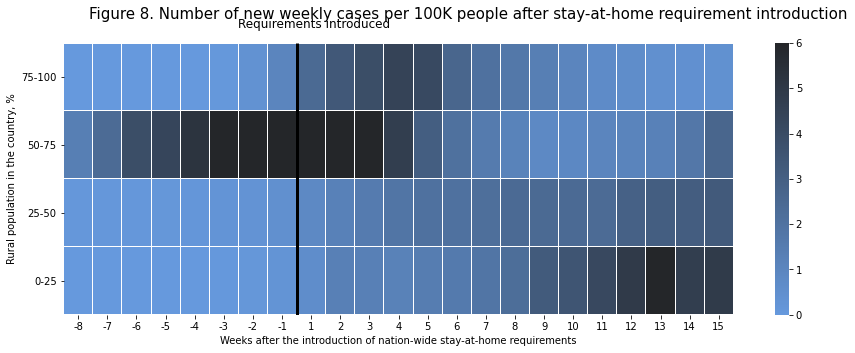

In [142]:
plot_cases(df_at_home_agg)

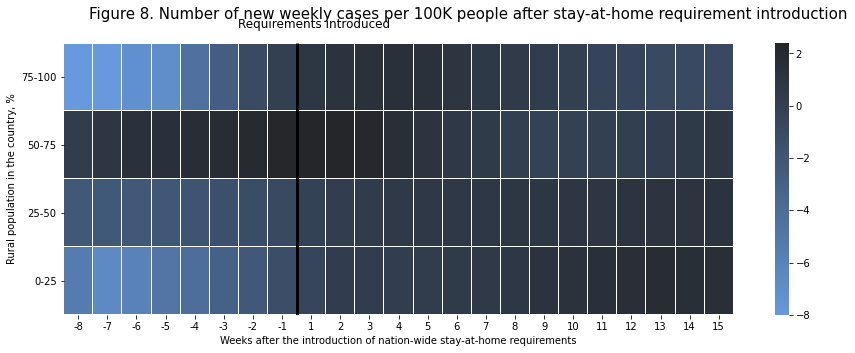

In [141]:
plot_cases(df_at_home_agg_log, set_params_max=True, vmin= -8, vmax = 2.4)

In [ ]:
def gov_intervention_plot(gov_df):
    """Plot the dates of when the government intervened for the first time in different rural regions.
    
    Args:
        gov_df (dataframe): Dataframe containing government response information
        
    Returns:
        None
    """
    
    # Get days when the government intervened with the policy
    df_plot = gov_df.loc[gov_df['days_after'] == 0, ['date', 'rural_category']]
    
    # Get date format
    date_format = mdates.DateFormatter('%b')
    
    # Create the plot
    fig, axs = plt.subplots(1,3, figsize=(15,4), sharex = True)
    fig.suptitle('Figure 7. Covid-19 and the first time of national stay at home requirements by rural area type')

    # Dictionary for looping
    rural_dict = {'Low': 0,
     'Medium': 1,
     'High': 2}

    # Configure each graph in a loop
    for category, i in rural_dict.items():
        sns.histplot(df_plot[df_plot['rural_category'] == category], x = 'date', ax = axs[i], bins = 10)
        axs[i].set_title(f"Rural category: {category}")
        axs[i].xaxis.set_major_formatter(date_format)
        axs[i].set_ylabel("Number of countries")
        if i != 0: axs[i].set_ylabel("")
   
    
    # Add annotation
    annotation_text = """Note: The y-axes are different for each plot to showcase the relative distributions within each group"""
    annotate_plot(annotation_text, top = 0.8, bottom = 0.2,  x1=.06, x2=.05)


# 5. Running regressions

In [2]:
df = pd.read_csv('2021-01-04 final_data.csv')

In [3]:
df.head()

country  month  individualism_index  confirmed    dead  population  \
0  Argentina    2.0                 46.0        0.0     0.0  44938712.0   
1  Argentina    3.0                 46.0      820.0    20.0  44938712.0   
2  Argentina    4.0                 46.0     4201.0   207.0  44938712.0   
3  Argentina    5.0                 46.0    14702.0   510.0  44938712.0   
4  Argentina    6.0                 46.0    59933.0  1245.0  44938712.0   

   health_expenditure  gdp_per_capita  population_ages_65_and_above_total  \
0            9.124315     9729.141574                           5052508.0   
1            9.124315     9729.141574                           5052508.0   
2            9.124315     9729.141574                           5052508.0   
3            9.124315     9729.141574                           5052508.0   
4            9.124315     9729.141574                           5052508.0   

   population_density  ...       capital      distance  continent  \
0            16.25851  ...  Buenos Aires  19206.559549         SA   
1            16.25851  ...  Buenos Aires  19206.559549         SA   
2            16.25851  ...  Buenos Aires  19206.559549         SA   
3            16.25851  ...  Buenos Aires  19206.559549         SA   
4            16.25851  ...  Buenos Aires  19206.559549         SA   

   confirmed_log  cases_neighbors  distance_log  individualism_gov  \
0     -29.933606         0.000474      9.863007         353.740000   
1       6.709304         5.122697      9.863007        2072.641290   
2       8.343078        23.515800      9.863007        3757.740000   
3       9.595739       138.163769      9.863007        3611.756774   
4      11.000983       318.002633      9.863007        3575.672000   

   individualism_mob  health_expenditure_log  gdp_per_capita_log  
0         -32.791687                2.210943            9.182881  
1       -1506.103166                2.210943            9.182881  
2       -3130.225314                2.210943            9.182881  
3       -2817.033416                2.210943            9.182881  
4       -2429.974159                2.210943            9.182881  

[5 rows x 31 columns]

In [5]:
def export_csv(df, export_no_two=True, 
               export_dummies=True, 
               export_dummies_no_two=False,
               mean_vars_export=False,
               vars_to_mean = ['individualism_index',
                             'health_expenditure',
                             'gdp_per_capita',
                             'over65_per_capita',
                             'population_density',
                             'mobility_index',
                             'containment_health_index',
                             'democracy_index',
                             'distance']):
    
    if export_no_two:
        df[df.month != 2].to_csv('2021-01-04 clean_data_from_3.csv', index=False)
        
    if export_dummies:
        df_cont = pd.concat((df.drop('continent', axis=1), pd.get_dummies(df['continent'], prefix = 'continent').iloc[:,0:5]), axis=1)
        df_cont.to_csv("2021-01-03 clean_data_w_dummies.csv", index=False)
        
    if export_dummies_no_two:
        df_cont[df_cont.month != 2].to_csv("2021-01-03 clean_data_w_dummies.csv", index=False)
        
    if mean_vars_export:
       
        vars_no_mean = [x for x in df_cont.columns if x not in vars_to_mean]
        df_cont_mean_centered = pd.concat((df_cont[vars_no_mean], df_cont[vars_to_mean] - df_cont[vars_to_mean].mean()), axis = 1)
        df_cont_mean_centered[df_cont_mean_centered.month != 2].to_csv('2021-01-03 clean_data_w_dummies_centered.csv')

## 5.1. Regression with total cases as of date

### 5.1.1. Getting interaction effects

In [552]:
df_newest = df[df.month==12]

In [553]:
df_newest = df_newest.set_index('country')

In [554]:
df_newest['mobility_index_avg'] = df.groupby('country').mobility_index.mean()
df_newest['containment_health_index_avg'] = df.groupby('country').containment_health_index.mean()

In [32]:
# Adding new changes to the model
def get_interactions(df, month_12=False):
    if month_12:
        df['individualism_gov'] = df['individualism_index'] * df['containment_health_index_avg']
        df['individualism_mob'] = df['individualism_index'] * df['mobility_index_avg']
    else:
        df['individualism_gov'] = df['individualism_index'] * df['containment_health_index']
        df['individualism_mob'] = df['individualism_index'] * df['mobility_index']
    return df



In [ ]:
df_newest = get_interactions(df_newest, month_12=True)

In [556]:
df_newest.columns

Index(['month', 'individualism_index', 'confirmed', 'dead', 'population',
       'health_expenditure', 'gdp_per_capita',
       'population_ages_65_and_above_total', 'population_density',
       'over65_per_capita', 'population_total', 'new_cases_per_100k',
       'new_cases_total', 'new_deaths_total', 'new_cases_total_log',
       'new_cases_per_100k_log', 'new_deaths_total_log', 'mobility_index',
       'containment_health_index', 'democracy_index', 'capital', 'distance',
       'continent', 'confirmed_log', 'cases_neighbors', 'distance_log',
       'individualism_gov', 'individualism_mob', 'health_expenditure_log',
       'gdp_per_capita_log', 'season', 'mobility_index_avg',
       'containment_health_index_avg'],
      dtype='object')

### 5.1.2. Results with Tanzania

In [65]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 'continent',  'individualism_gov',
              'cases_neighbors']

<AxesSubplot:>

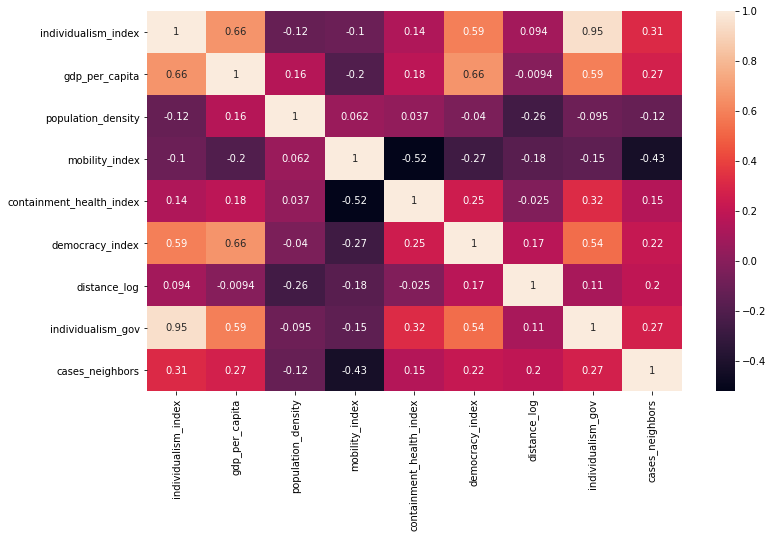

In [66]:
fig, ax, = plt.subplots(figsize=(12,7))
sns.heatmap(df_newest[vars_to_use].corr(), annot=True)

In [127]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index_avg', 'containment_health_index_avg', 'democracy_index', 'distance_log', 'continent', 'individualism_gov', 'cases_neighbors']
results_total2 = smf.ols('confirmed_log ~ ' + ' + '.join(vars_to_use), data = df_newest[df_newest != 'Tanzania']).fit()

In [68]:
results_total = smf.ols('confirmed_log ~ ' + ' + '.join(vars_to_use), data = df_newest).fit()

In [69]:
results_total.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          confirmed_log   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     4.390
Date:                Thu, 07 Jan 2021   Prob (F-statistic):           3.11e-05
Time:                        08:16:26   Log-Likelihood:                -126.84
No. Observations:                  72   AIC:                             283.7
Df Residuals:                      57   BIC:                             317.8
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -0.6880      7.282     -0.094      0.925     -15.269      13.893
continent[T.AS]                  2.2030      1.114      1.977      0.053      -0.028       4.434
continent[T.EU]                  1.5799      1.001      1.578      0.120      -0.424       3.584
continent[T.N.A.]                0.6526      0.992      0.658      0.513      -1.334       2.639
continent[T.OC]                 -2.3992      1.457     -1.647      0.105      -5.317       0.519
continent[T.SA]                  1.9441      1.122      1.732      0.089      -0.303       4.191
individualism_index             -0.0312      0.067     -0.464      0.645      -0.166       0.104
gdp_per_capita               -7.994e-06    1.3e-05     -0.615      0.541    -3.4e-05     1.8e-05
population_density              -0.0001      0.000     -0.657      0.514      -0.001       0.000
mobility_index_avg               0.0098      0.024      0.406      0.686      -0.039       0.058
containment_health_index_avg     0.0597      0.055      1.084      0.283      -0.051       0.170
democracy_index                 -0.0118      0.017     -0.713      0.479      -0.045       0.021
distance_log                     0.8928      0.719      1.242      0.219      -0.547       2.333
individualism_gov                0.0013      0.001      1.039      0.303      -0.001       0.004
cases_neighbors                  0.0002      0.001      0.420      0.676      -0.001       0.001
==============================================================================
Omnibus:                        7.626   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.171
Skew:                          -0.620   Prob(JB):                       0.0277
Kurtosis:                       3.922   Cond. No.                     1.34e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
results_df = pd.DataFrame()
results_df = results_df.append(results.pvalues, ignore_index=True)
params_ = results.params
p_ = results.pvalues

### 5.1.3. Results without Tanzania

In [557]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index_avg', 'containment_health_index_avg', 'democracy_index', 'distance_log', 'continent', 'individualism_gov', 'cases_neighbors']

In [558]:
df_newest2 = df_newest[df_newest.index != 'Tanzania']

In [559]:
results_total2 = smf.ols('confirmed_log ~ ' + ' + '.join(vars_to_use), data = df_newest[df_newest.index != 'Tanzania']).fit()
results_total2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          confirmed_log   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     3.553
Date:                Thu, 07 Jan 2021   Prob (F-statistic):           0.000348
Time:                        14:42:34   Log-Likelihood:                -124.36
No. Observations:                  71   AIC:                             278.7
Df Residuals:                      56   BIC:                             312.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        1.8644      7.447      0.250      0.803     -13.053      16.782
continent[T.AS]                  2.0664      1.109      1.863      0.068      -0.155       4.288
continent[T.EU]                  1.4363      0.998      1.439      0.156      -0.563       3.435
continent[T.N.A.]                0.5697      0.985      0.578      0.565      -1.404       2.544
continent[T.OC]                 -2.6646      1.457     -1.829      0.073      -5.584       0.255
continent[T.SA]                  1.8619      1.114      1.671      0.100      -0.370       4.094
individualism_index             -0.0606      0.070     -0.866      0.390      -0.201       0.080
gdp_per_capita               -8.437e-06   1.29e-05     -0.654      0.516   -3.43e-05    1.74e-05
population_density              -0.0001      0.000     -0.665      0.509      -0.001       0.000
mobility_index_avg               0.0047      0.024      0.196      0.846      -0.044       0.053
containment_health_index_avg     0.0180      0.062      0.290      0.773      -0.107       0.143
democracy_index                 -0.0109      0.016     -0.662      0.511      -0.044       0.022
distance_log                     0.8620      0.713      1.208      0.232      -0.567       2.291
individualism_gov                0.0018      0.001      1.437      0.156      -0.001       0.004
cases_neighbors                  0.0002      0.001      0.264      0.793      -0.001       0.001
==============================================================================
Omnibus:                        9.036   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.788
Skew:                          -0.715   Prob(JB):                       0.0124
Kurtosis:                       3.962   Cond. No.                     1.38e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [560]:
result_summ = summary_col([results_total2], stars=True)
res_df = result_summ.tables[0]
res_df.columns = ['Cumulative']

In [561]:
with open('cumulative_regression.tex','w') as tf:
    tf.write(res_df.to_latex())

## 5.2. Regression for different months

In [4]:
df.columns

Index(['country', 'month', 'individualism_index', 'confirmed', 'dead',
       'population', 'health_expenditure', 'gdp_per_capita',
       'population_ages_65_and_above_total', 'population_density',
       'over65_per_capita', 'population_total', 'new_cases_per_100k',
       'new_cases_total', 'new_deaths_total', 'new_cases_total_log',
       'new_cases_per_100k_log', 'new_deaths_total_log', 'mobility_index',
       'containment_health_index', 'democracy_index', 'capital', 'distance',
       'continent', 'confirmed_log', 'cases_neighbors', 'distance_log',
       'individualism_gov', 'individualism_mob', 'health_expenditure_log',
       'gdp_per_capita_log'],
      dtype='object')

In [587]:
df['containment_health_index'].max()

87.693

In [588]:
'new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use)

'new_cases_per_100k_log ~ individualism_index + gdp_per_capita + population_density + mobility_index + containment_health_index + democracy_index + distance_log + continent + individualism_gov + cases_neighbors'

In [589]:
result_dict = {}

In [5]:
df3 = df[df.country != 'Tanzania'].copy()

In [591]:
# Create many variables in a for-loop

monthly_vars = {}
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 'continent',  'individualism_gov',
              'cases_neighbors']

for i in range(2,13):
    results = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df[df.month == i]).fit()
    monthly_vars['month_{}'.format(i)] = results

In [595]:
for k,v in monthly_vars.items():
    monthly_vars[k] = v.get_robustcov_results()

In [596]:
rs_list = list(monthly_vars.values())


In [605]:
result_summ = summary_col(rs_list[0:6], stars=True)
res_df1 = result_summ.tables[0]
res_df1.columns = [f'Month_{x}' for x in range(2,8)]

with open('summary_monthly1.tex','w') as tf:
    tf.write(res_df1.to_latex())

In [606]:
result_summ = summary_col(rs_list[6:], stars=True)
res_df2 = result_summ.tables[0]
res_df2.columns = [f'Month_{x}' for x in range(8,13)]
with open('summary_monthly2.tex','w') as tf:
    tf.write(res_df2.to_latex())

In [592]:
res_df1 = results_months1.tables[0]
res_df1.columns = [f'Month_{x}' for x in range(2,8)]

res_df2 = results_months2.tables[0]
res_df2.columns = [f'Month_{x}' for x in range(8,13)]

In [ ]:
with open('summary_seasonal.tex','w') as tf:
    tf.write(res_df.to_latex())

In [578]:
df3 = df[df.country != 'Tanzania'].copy()

In [579]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 'continent',  'individualism_gov',
              'cases_neighbors']

for month in range(2,13):
    results = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df[df.month == month]).fit()
    print(f"\n\n------------------- MONTH: {month} -----------------------")
    print(results.summary())
    result_dict[str(month) + '_pvalues'] = results.pvalues
    result_dict[str(month) + '_params'] = results.params



------------------- MONTH: 2 -----------------------
                              OLS Regression Results                              
Dep. Variable:     new_cases_per_100k_log   R-squared:                       0.442
Model:                                OLS   Adj. R-squared:                  0.305
Method:                     Least Squares   F-statistic:                     3.222
Date:                    Thu, 07 Jan 2021   Prob (F-statistic):           0.000883
Time:                            15:04:27   Log-Likelihood:                -202.82
No. Observations:                      72   AIC:                             435.6
Df Residuals:                          57   BIC:                             469.8
Df Model:                              14                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------

In [580]:
result_dict.keys()

dict_keys(['2_pvalues', '2_params', '3_pvalues', '3_params', '4_pvalues', '4_params', '5_pvalues', '5_params', '6_pvalues', '6_params', '7_pvalues', '7_params', '8_pvalues', '8_params', '9_pvalues', '9_params', '10_pvalues', '10_params', '11_pvalues', '11_params', '12_pvalues', '12_params'])

In [581]:
pvalues_df = pd.DataFrame()
coeff_df = pd.DataFrame()

In [582]:
for key in result_dict.keys():
    if '_pvalues' in key:
        result_series = result_dict[key]
        pvalues_df = pvalues_df.append(result_series, ignore_index=True)
        
    if '_params' in key:
        params_series = result_dict[key]
        coeff_df = coeff_df.append(params_series, ignore_index=True)

In [583]:
pvalues_df.index = range(2,13)
coeff_df.index = range(2,13)

## 5.3. Regression for different seasons

### 5.3.1. Regression model summaries

In [16]:
seasons_dict = {'2': 'winter_1',
                '3': 'spring',
                '4': 'spring',
                '5': 'spring',
                '6': 'summer',
                '7': 'summer',
                '8': 'summer',
                '9': 'autumn',
                '10': 'autumn',
                '11': 'autumn',
                '12': 'winter_2'}

seasons_dict = {int(k):v for k,v in seasons_dict.items()}

In [17]:
df['season'] = df['month'].map(seasons_dict)

In [18]:
vars_to_agg = ['individualism_index', 'health_expenditure', 'gdp_per_capita', 'over65_per_capita',
               'population_density', 
               'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log',  'individualism_gov', 'cases_neighbors']

dict_for_agg = {v:'mean' for v in vars_to_agg}
dict_for_agg.update({'new_cases_per_100k': 'sum'})

In [19]:
df_seasons = df.groupby(['country', 'season', 'continent']).agg(dict_for_agg).reset_index()
df_seasons['new_cases_per_100k_log'] = np.log(df_seasons['new_cases_per_100k'] + 0.0000000001)

In [20]:
df_seasons = df_seasons.set_index('country')

In [22]:
from statsmodels.iolib.summary2 import summary_col

In [23]:
df.season.unique()

array(['winter_1', 'spring', 'summer', 'autumn', 'winter_2'], dtype=object)

In [24]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 'continent',  'individualism_gov', 'cases_neighbors']


In [25]:
results1 = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df_seasons[df_seasons.season == 'winter_1']).fit()
results2 = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df_seasons[df_seasons.season == 'spring']).fit()
results3 = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df_seasons[df_seasons.season == 'summer']).fit()
results4 = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df_seasons[df_seasons.season == 'autumn']).fit()
results5 = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df_seasons[df_seasons.season == 'winter_2']).fit()


In [26]:
def get_season_vars(with_tanzania=True):
    season_vars = {}
    vars_to_use = ['individualism_index', 'gdp_per_capita', 
                   'population_density', 
                   'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 'continent',  'individualism_gov',
                  'cases_neighbors']

    if with_tanzania:
        for season in ['winter_1', 'spring', 'summer', 'autumn', 'winter_2']:
            results = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df_seasons[df_seasons['season'] == season]).fit()
            season_vars['{}'.format(season)] = results
            
    else:
        for season in ['winter_1', 'spring', 'summer', 'autumn', 'winter_2']:
            results = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df_seasons[
                (df_seasons['season'] == season) & (df_seasons.index != 'Tanzania')]).fit()
            season_vars['{}'.format(season)] = results
        
    return season_vars

In [27]:
season_vars = get_season_vars(with_tanzania=False)

In [29]:
season_vars

{'winter_1': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2198e28a7f0>,
 'spring': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2198e299ca0>,
 'summer': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2198dfedd00>,
 'autumn': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2198e2b2cd0>,
 'winter_2': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2198e2bf4f0>}

### 5.3.2. Regression model summaries with robust standard errors and without Tanzania

In [ ]:
season_vars2 = get_season_vars(with_tanzania=False)
season_vars2['cumulative'] = results_total2

In [528]:
keys_list = list(season_vars2.keys())
keys_list.insert(0, keys_list.pop())
season_vars2 = dict(sorted(season_vars2.items(), key = lambda pair: keys_list.index(pair[0])))

In [531]:
for key, value in season_vars2.items():
    season_vars2[key] = value.get_robustcov_results()

In [532]:
season_vars2

{'cumulative': <statsmodels.regression.linear_model.OLSResults at 0x2299ae475b0>,
 'winter_1': <statsmodels.regression.linear_model.OLSResults at 0x2299dd05b80>,
 'spring': <statsmodels.regression.linear_model.OLSResults at 0x2299d5322b0>,
 'summer': <statsmodels.regression.linear_model.OLSResults at 0x2299d8a6d60>,
 'autumn': <statsmodels.regression.linear_model.OLSResults at 0x2299d534040>,
 'winter_2': <statsmodels.regression.linear_model.OLSResults at 0x2299d9401f0>}

In [533]:
rs_list = list(season_vars2.values())[1:]
result_summ = summary_col(rs_list, stars=True)


In [534]:
res_df = result_summ.tables[0]
res_df.columns = ['Winter1', 'Spring', 'Summer', 'Autumn', 'Winter2']

In [622]:
res_df

Cumulative
Intercept                        1.8644
                               (7.4468)
continent[T.AS]                 2.0664*
                               (1.1091)
continent[T.EU]                  1.4363
                               (0.9978)
continent[T.N.A.]                0.5697
                               (0.9854)
continent[T.OC]                -2.6646*
                               (1.4573)
continent[T.SA]                  1.8619
                               (1.1143)
individualism_index             -0.0606
                               (0.0700)
gdp_per_capita                  -0.0000
                               (0.0000)
population_density              -0.0001
                               (0.0002)
mobility_index_avg               0.0047
                               (0.0243)
containment_health_index_avg     0.0180
                               (0.0622)
democracy_index                 -0.0109
                               (0.0164)
distance_log                     0.8620
                               (0.7133)
individualism_gov                0.0018
                               (0.0013)
cases_neighbors                  0.0002
                               (0.0006)
R-squared                        0.4704
R-squared Adj.                   0.3380

In [535]:
with open('summary_seasonal.tex','w') as tf:
    tf.write(res_df.to_latex())

### 5.3.3. Regression models with Tanzania

In [47]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 'continent',  'individualism_gov', 'cases_neighbors']

for season in df.season.unique():
    
    results = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df_seasons[df_seasons.season == season]).fit()
    print(f"\n\n------------------- Season: {season} -----------------------")
    print(results.summary())
    
season_vars = get_season_vars(with_tanzania=False)



------------------- Season: winter_1 -----------------------
                              OLS Regression Results                              
Dep. Variable:     new_cases_per_100k_log   R-squared:                       0.414
Model:                                OLS   Adj. R-squared:                  0.270
Method:                     Least Squares   F-statistic:                     2.879
Date:                    Tue, 05 Jan 2021   Prob (F-statistic):            0.00246
Time:                            22:57:08   Log-Likelihood:                -248.22
No. Observations:                      72   AIC:                             526.4
Df Residuals:                          57   BIC:                             560.6
Df Model:                              14                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------

### 5.3.4. Without Tanzania

#### 5.3.4.1. No continents

In [623]:
def get_season_vars(with_tanzania=True, vars_to_use = ['individualism_index', 'gdp_per_capita', 
                   'population_density', 
                   'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 'continent',  'individualism_gov',
                  'cases_neighbors']):
    season_vars = {}
    
    if with_tanzania:
        for season in ['winter_1', 'spring', 'summer', 'autumn', 'winter_2']:
            results = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df_seasons[df_seasons['season'] == season]).fit()
            season_vars['{}'.format(season)] = results
            
    else:
        for season in ['winter_1', 'spring', 'summer', 'autumn', 'winter_2']:
            results = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df_seasons[
                (df_seasons['season'] == season) & (df_seasons.index != 'Tanzania')]).fit()
            season_vars['{}'.format(season)] = results
        
    return season_vars

In [625]:
season_vars = get_season_vars(with_tanzania=False, vars_to_use = ['individualism_index', 'gdp_per_capita', 
                   'population_density', 
                   'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 'individualism_gov',
                  'cases_neighbors'])

In [626]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index_avg', 'containment_health_index_avg', 'democracy_index', 'distance_log', 'individualism_gov', 'cases_neighbors']
results_total_no_continent = smf.ols('confirmed_log ~ ' + ' + '.join(vars_to_use), data = df_newest[df_newest != 'Tanzania']).fit()

In [627]:
season_vars['cumulative'] = results_total_no_continent
keys_list = list(season_vars.keys())
keys_list.insert(0, keys_list.pop())
season_vars = dict(sorted(season_vars.items(), key = lambda pair: keys_list.index(pair[0])))

In [638]:
rs_list = list(season_vars.values())
result_summ = summary_col(rs_list, stars=True)


In [639]:
table_nocont = result_summ.tables[0]
table_nocont.columns = ['cumulative', 'winter_1', 'spring', 'summer', 'autumn', 'winter_2']

In [640]:
with open('no_continent_reg.tex','w') as tf:
    tf.write(table_nocont.to_latex())

In [621]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log',  'individualism_gov', 'cases_neighbors']

for season in df.season.unique():
    
    results = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df_seasons[(df_seasons.season == season) & (df_seasons.index != 'Tanzania')]).fit()
    print(f"\n\n------------------- Season: {season} -----------------------")
    print(results.summary())



------------------- Season: winter_1 -----------------------
                              OLS Regression Results                              
Dep. Variable:     new_cases_per_100k_log   R-squared:                       0.397
Model:                                OLS   Adj. R-squared:                  0.308
Method:                     Least Squares   F-statistic:                     4.468
Date:                    Thu, 07 Jan 2021   Prob (F-statistic):           0.000159
Time:                            18:59:03   Log-Likelihood:                -245.75
No. Observations:                      71   AIC:                             511.5
Df Residuals:                          61   BIC:                             534.1
Df Model:                               9                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------

#### 5.3.4.2. Continents

In [509]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 'continent',  'individualism_gov', 'cases_neighbors']

for season in df.season.unique():
    
    results = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df_seasons[(df_seasons.season == season) & (df_seasons.index != 'Tanzania')]).fit()
    print(f"\n\n------------------- Season: {season} -----------------------")
    print(results.summary())



------------------- Season: winter_1 -----------------------
                              OLS Regression Results                              
Dep. Variable:     new_cases_per_100k_log   R-squared:                       0.409
Model:                                OLS   Adj. R-squared:                  0.262
Method:                     Least Squares   F-statistic:                     2.772
Date:                    Thu, 07 Jan 2021   Prob (F-statistic):            0.00347
Time:                            14:02:06   Log-Likelihood:                -245.04
No. Observations:                      71   AIC:                             520.1
Df Residuals:                          56   BIC:                             554.0
Df Model:                              14                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------

### 5.3.5. Regression without an interaction effect

In [14]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 'continent', 'cases_neighbors']

for season in df.season.unique():
    
    results = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df_seasons[df_seasons.season == season]).fit()
    print(f"\n\n------------------- Season: {season} -----------------------")
    print(results.summary())



------------------- Season: winter_1 -----------------------
                              OLS Regression Results                              
Dep. Variable:     new_cases_per_100k_log   R-squared:                       0.397
Model:                                OLS   Adj. R-squared:                  0.262
Method:                     Least Squares   F-statistic:                     2.936
Date:                    Wed, 06 Jan 2021   Prob (F-statistic):            0.00246
Time:                            11:18:18   Log-Likelihood:                -249.27
No. Observations:                      72   AIC:                             526.5
Df Residuals:                          58   BIC:                             558.4
Df Model:                              13                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------

In [48]:
import seaborn as sns

<AxesSubplot:>

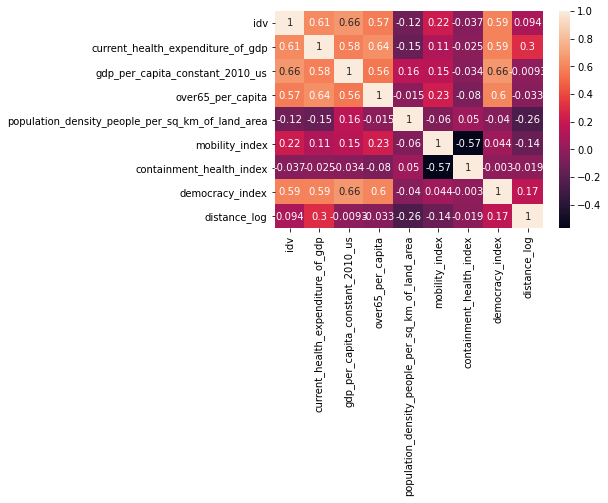

In [45]:
sns.heatmap(df_seasons[vars_to_use].corr(), annot=True)

# 6. Diagnostics

In [109]:
import statsmodels.api as sm

## 6.1. Regression with total cases

### 6.1.1. Homoscedasticity of residuals + functional misspecification

In [202]:
def get_plot(results_total, df_newest, savefig = False):
    fitted_vals = results_total.predict()
    resids = results_total.resid
    y = df_newest['confirmed_log']
    
    fig, ax = plt.subplots(1,2, figsize = (12,6))
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'grey'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=14)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'grey'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=14)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')

    if savefig:
        fig.savefig('residuals_cumulative.png')

In [203]:
aut = df_seasons[df_seasons.season == 'autumn']

In [210]:
aut[season_vars['autumn'].resid < -15]

country  season continent  individualism_index  health_expenditure  \
310  Tanzania  autumn        AF                 25.0            3.645451   

     gdp_per_capita  over65_per_capita  population_density  mobility_index  \
310      985.448173           0.026205           63.579079      -11.187826   

     containment_health_index  democracy_index  distance_log  \
310                 17.363541             51.6      9.136094   

     individualism_gov  cases_neighbors  new_cases_per_100k  \
310          434.08853        10.597085                 0.0   

     new_cases_per_100k_log  
310              -23.025851

#### 6.1.1.1. Checking autumn data

In [37]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 'continent',  'individualism_gov', 'cases_neighbors']

season = 'autumn'    
results = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df_seasons[df_seasons.season == season]).fit()
print(f"\n\n------------------- Season: {season} -----------------------")
print(results.summary())



------------------- Season: autumn -----------------------
                              OLS Regression Results                              
Dep. Variable:     new_cases_per_100k_log   R-squared:                       0.595
Model:                                OLS   Adj. R-squared:                  0.495
Method:                     Least Squares   F-statistic:                     5.977
Date:                    Thu, 07 Jan 2021   Prob (F-statistic):           4.97e-07
Time:                            07:46:50   Log-Likelihood:                -168.86
No. Observations:                      72   AIC:                             367.7
Df Residuals:                          57   BIC:                             401.9
Df Model:                              14                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [34]:
df_seasons[(df_seasons['new_cases_per_100k'] == 0) & (df_seasons['season'] != 'winter_1')]

country    season continent  individualism_index  health_expenditure  \
310  Tanzania    autumn        AF                 25.0            3.645451   
312  Tanzania    summer        AF                 25.0            3.645451   
314  Tanzania  winter_2        AF                 25.0            3.645451   

     gdp_per_capita  over65_per_capita  population_density  mobility_index  \
310      985.448173           0.026205           63.579079      -11.187826   
312      985.448173           0.026205           63.579079       -4.145647   
314      985.448173           0.026205           63.579079       -2.186495   

     containment_health_index  democracy_index  distance_log  \
310                 17.363541             51.6      9.136094   
312                 26.077405             51.6      9.136094   
314                 14.700476             51.6      9.136094   

     individualism_gov  cases_neighbors  new_cases_per_100k  \
310         434.088530        10.597085                 0.0   
312         651.935125         9.552368                 0.0   
314         367.511905        14.925671                 0.0   

     new_cases_per_100k_log  
310              -23.025851  
312              -23.025851  
314              -23.025851

In [35]:
df_autumn = df_seasons[df_seasons.season == 'autumn']

In [38]:
def plot_values(results, df):
    fitted_vals = results.predict()
    resids = results.resid
    y = df['new_cases_per_100k_log']
    
    fig, ax = plt.subplots(1,2, figsize = (12,6))
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'grey'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=14)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'grey'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=14)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')

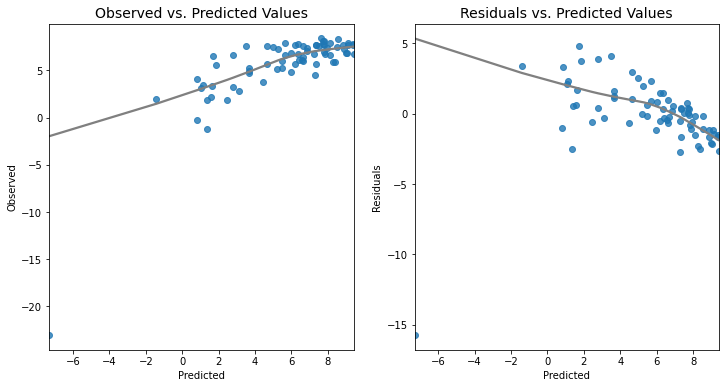

In [39]:
plot_values(results, df_seasons[df_seasons.season == 'autumn'])

Running the model without Tanzania

In [40]:
df_autumn = df_autumn[df_autumn.country != 'Tanzania']

In [41]:
results = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df_autumn).fit()
print(f"\n\n------------------- Season: {season} -----------------------")
print(results.summary())



------------------- Season: autumn -----------------------
                              OLS Regression Results                              
Dep. Variable:     new_cases_per_100k_log   R-squared:                       0.793
Model:                                OLS   Adj. R-squared:                  0.741
Method:                     Least Squares   F-statistic:                     15.31
Date:                    Thu, 07 Jan 2021   Prob (F-statistic):           2.53e-14
Time:                            07:46:58   Log-Likelihood:                -96.215
No. Observations:                      71   AIC:                             222.4
Df Residuals:                          56   BIC:                             256.4
Df Model:                              14                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [46]:
def plot_values(results, df):
    fitted_vals = results.predict()
    resids = results.resid
    y = df['new_cases_per_100k_log']
    
    fig, ax = plt.subplots(1,2, figsize = (12,6))
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'grey'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=14)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'grey'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=14)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')

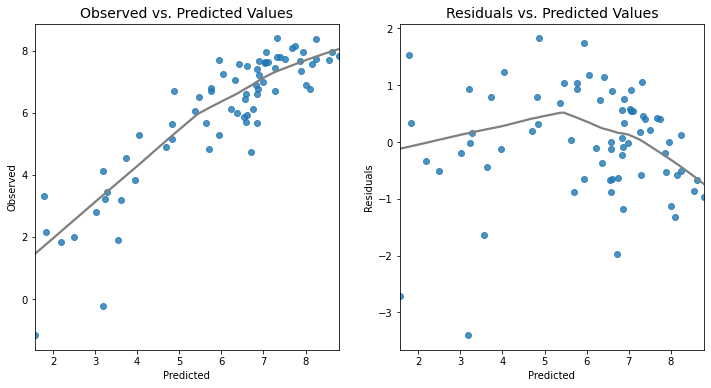

In [47]:
plot_values(results, df_autumn)

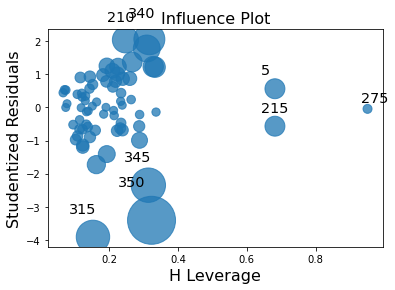

In [234]:
sm.graphics.influence_plot(results, criterion="cooks");

#### 6.1.1.2. Checking summer data

In [48]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 'continent',  'individualism_gov', 'cases_neighbors']

season = 'summer'    
results = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df_seasons[df_seasons.season == season]).fit()
print(f"\n\n------------------- Season: {season} -----------------------")
print(results.summary())



------------------- Season: summer -----------------------
                              OLS Regression Results                              
Dep. Variable:     new_cases_per_100k_log   R-squared:                       0.423
Model:                                OLS   Adj. R-squared:                  0.282
Method:                     Least Squares   F-statistic:                     2.991
Date:                    Thu, 07 Jan 2021   Prob (F-statistic):            0.00176
Time:                            08:02:02   Log-Likelihood:                -176.08
No. Observations:                      72   AIC:                             382.2
Df Residuals:                          57   BIC:                             416.3
Df Model:                              14                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------

In [49]:
df_summer = df_seasons[df_seasons.season == 'summer']

In [50]:
def plot_values(results, df):
    fitted_vals = results.predict()
    resids = results.resid
    y = df['new_cases_per_100k_log']
    
    fig, ax = plt.subplots(1,2, figsize = (12,6))
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'grey'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=14)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'grey'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=14)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')

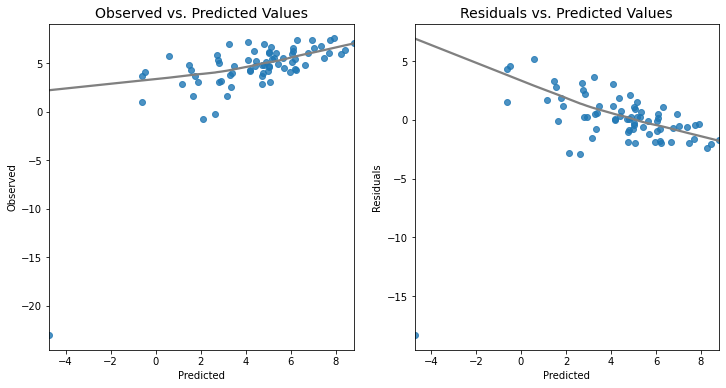

In [51]:
plot_values(results, df_seasons[df_seasons.season == 'summer'])

Running the model without Tanzania

In [52]:
df_summer = df_summer[df_summer.country != 'Tanzania']

In [53]:
results = smf.ols('new_cases_per_100k_log ~ ' + ' + '.join(vars_to_use), data = df_summer).fit()
print(f"\n\n------------------- Season: {season} -----------------------")
print(results.summary())



------------------- Season: summer -----------------------
                              OLS Regression Results                              
Dep. Variable:     new_cases_per_100k_log   R-squared:                       0.523
Model:                                OLS   Adj. R-squared:                  0.404
Method:                     Least Squares   F-statistic:                     4.388
Date:                    Thu, 07 Jan 2021   Prob (F-statistic):           3.33e-05
Time:                            08:02:14   Log-Likelihood:                -112.70
No. Observations:                      71   AIC:                             255.4
Df Residuals:                          56   BIC:                             289.3
Df Model:                              14                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------

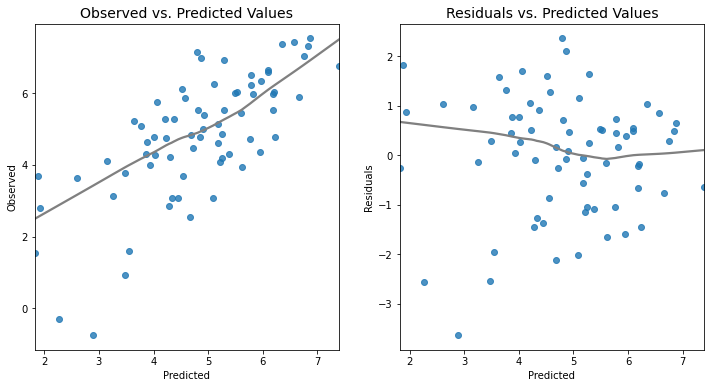

In [54]:
plot_values(results, df_summer)

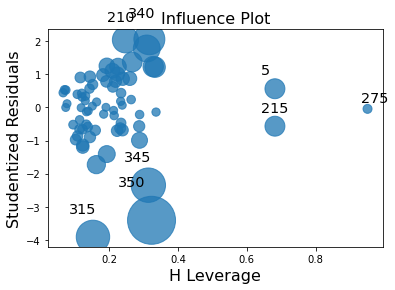

In [234]:
sm.graphics.influence_plot(results, criterion="cooks");

#### 6.1.1.3. Diagnostics for all seasons

In [421]:
season_vars = get_season_vars(with_tanzania=False)

In [422]:
season_vars['cumulative'] = results_total2
keys_list = list(season_vars.keys())
keys_list.insert(0, keys_list.pop())
season_vars = dict(sorted(season_vars.items(), key = lambda pair: keys_list.index(pair[0])))

In [410]:
df_seasons2 = df_seasons[df_seasons.index != 'Tanzania'].copy()

In [285]:
season_vars.keys()

dict_keys(['cumulative', 'winter_1', 'spring', 'summer', 'autumn', 'winter_2'])

In [286]:
item_plots = {'cumulative': [0,1],
              'winter_1': [2,3],
              'spring': [4,5],
              'summer': [6,7],
              'autumn': [8,9],
              'winter_2': [10,11]}

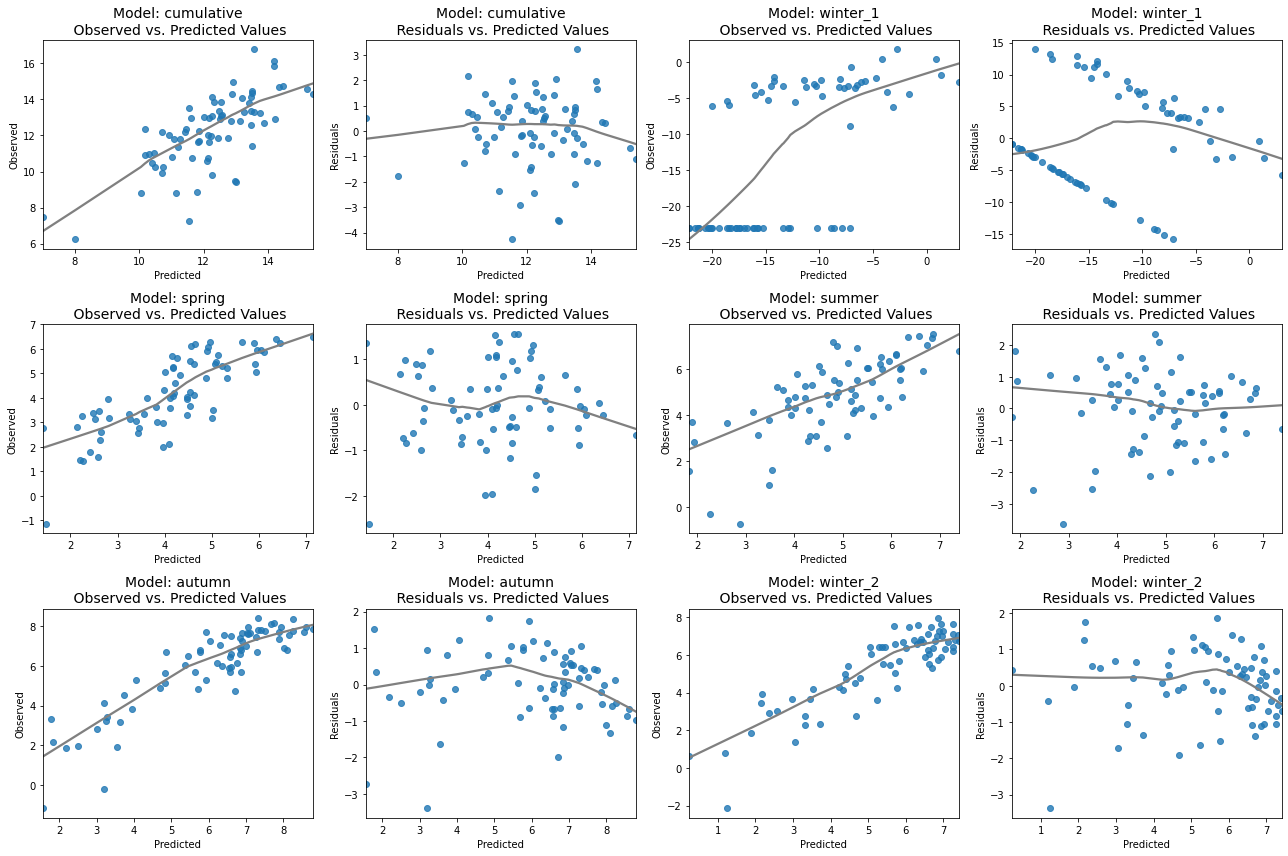

In [256]:
fig, axs = plt.subplots(3,4, figsize = (18,12))

ax_list = [item for sublist in axs for item in sublist]

for season, model in season_vars.items():

    fitted_vals = model.predict()
    resids = model.resid
    if season == 'cumulative': y = df_newest['confirmed_log']
    else: y = df_seasons2.loc[(df_seasons2.season == season, 'new_cases_per_100k_log') ]

    # get items
    plots = item_plots[season]
    
    for plot in plots:
        ax = ax_list.pop(0)
        
        if plot % 2 == 0:
            sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax, line_kws={'color': 'grey'})
            ax.set_title(f'Model: {season}\n Observed vs. Predicted Values', fontsize=14)
            ax.set(xlabel='Predicted', ylabel='Observed')
        else:
            sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax, line_kws={'color': 'grey'})
            ax.set_title(f'Model: {season}\n Residuals vs. Predicted Values', fontsize=14)
            ax.set(xlabel='Predicted', ylabel='Residuals')
            
plt.tight_layout()
fig.savefig('resids.png')

In [173]:
season_vars

{'cumulative': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1d3213c61f0>,
 'winter_1': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1d32243d8b0>,
 'spring': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1d3249ba7f0>,
 'summer': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1d3249c9fa0>,
 'autumn': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1d3249db340>,
 'winter_2': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x1d3249e9220>}

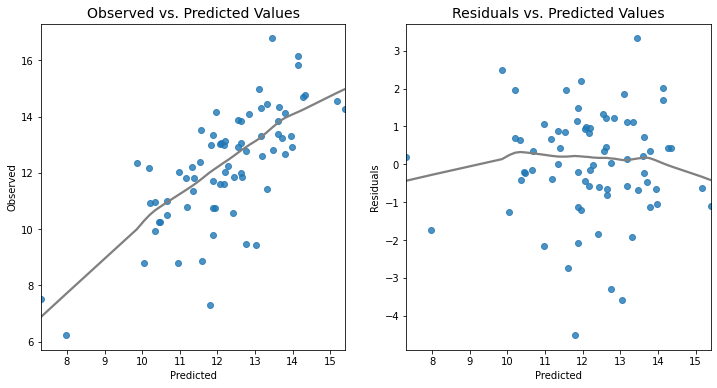

In [114]:
get_plot(results_total, df_newest, savefig=True)

### 6.1.2. Multicolinearity

In [148]:
from functools import reduce

In [150]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 'individualism_gov',
              'cases_neighbors']

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(df[vars_to_use].values, i) for i in range(df[vars_to_use].shape[1])]
vif['variable'] = df[vars_to_use].columns

In [156]:
season_vars

{'cumulative': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2299a6c4370>,
 'winter_1': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2299c1ade80>,
 'spring': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2299c2a6c70>,
 'summer': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2299c5532b0>,
 'autumn': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2299c56ff40>,
 'winter_2': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2299c566f40>}

#### 6.1.2.1.Overall model

In [166]:
df2 = df.copy()
df2 = pd.concat((df2.drop('continent', axis=1), pd.get_dummies(df2['continent'])), axis=1)

In [174]:
df2 = df2.rename(columns={'N.A.': 'NA'})

In [197]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 
              'cases_neighbors', 'AF', 'AS', 'EU', 'NA', 'OC']

def join_strings(xs, sep):
    return reduce(lambda a, b: a + sep + b, xs)
    
vifs = {}

for v in vars_to_use:
    cns = vars_to_use.copy()
    cns.remove(v)
    formula = v + " ~ " + join_strings(cns, " + ")
    coef_det = smf.ols(formula, data = df2).fit()
    vif = 1 / (1 - coef_det.rsquared)
    vifs[v] = vif
    if vif > 3:
        print("\n" + 80 * "=")
        print(v)
        print(vif)
        
multicolinearity_df = pd.DataFrame(vifs.items())


distance_log
4.529382769257378

AS
9.840883109482503

EU
6.892263022892055


In [199]:
with open('corr_coef.tex','w') as tf:
    tf.write(df2[vars_to_use].corr().to_latex())

In [206]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 
              'cases_neighbors']

In [207]:
df_corr = df2[vars_to_use].corr()

In [209]:
df2_c = df2[vars_to_use]
df2_c.columns = ['ind', 'gdp' ,'popdens', 'mob', 'health', 'democr', 'dist', 'neighb']

In [211]:
df2_c.corr()

with open('corr_coef.tex','w') as tf:
    tf.write(df2_c.corr().to_latex())

In [180]:
multicolinearity_df.columns = ['Variable', 'VIF']

In [186]:
with open('multicolinearity.tex','w') as tf:
    tf.write(multicolinearity_df.to_latex())

### 6.1.3. Homoscedasticity of residuals

In [411]:
import statsmodels.stats.api as sms

In [412]:
stder = {}
for season, fit in season_vars.items():
    stder[season] = {}


names = ['Lagrange multiplier statistic', 'p-value',
        'F-statistic', 'p-value for F-statistic']
for season, fit in season_vars.items():
    test = sms.het_breuschpagan(fit.resid, fit.model.exog)
    items = {*(zip(names,test))}
    for it in items:
        stder[season][it[0]] = it[1]
    

In [388]:
stder = pd.DataFrame(stder).round(4)

In [389]:
with open('breuschp.tex','w') as tf:
    tf.write(stder.to_latex())

In [ ]:
OLSResults.et_robustcov_results()

### 6.1.4. Autocorrelation of residuals

In [56]:
import statsmodels.tsa.api as smt


<ipython-input-86-5396dca5761b>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acf.show()


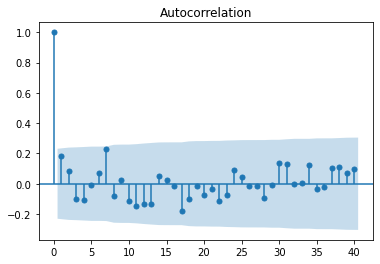

In [86]:
acf = smt.graphics.plot_acf(results_total.resid, lags=40 , alpha=0.05)
acf.show()

In [225]:
season_vars

{'cumulative': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2299a6c4370>,
 'winter_1': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2299c1ade80>,
 'spring': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2299c2a6c70>,
 'summer': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2299c5532b0>,
 'autumn': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2299c56ff40>,
 'winter_2': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x2299c566f40>}

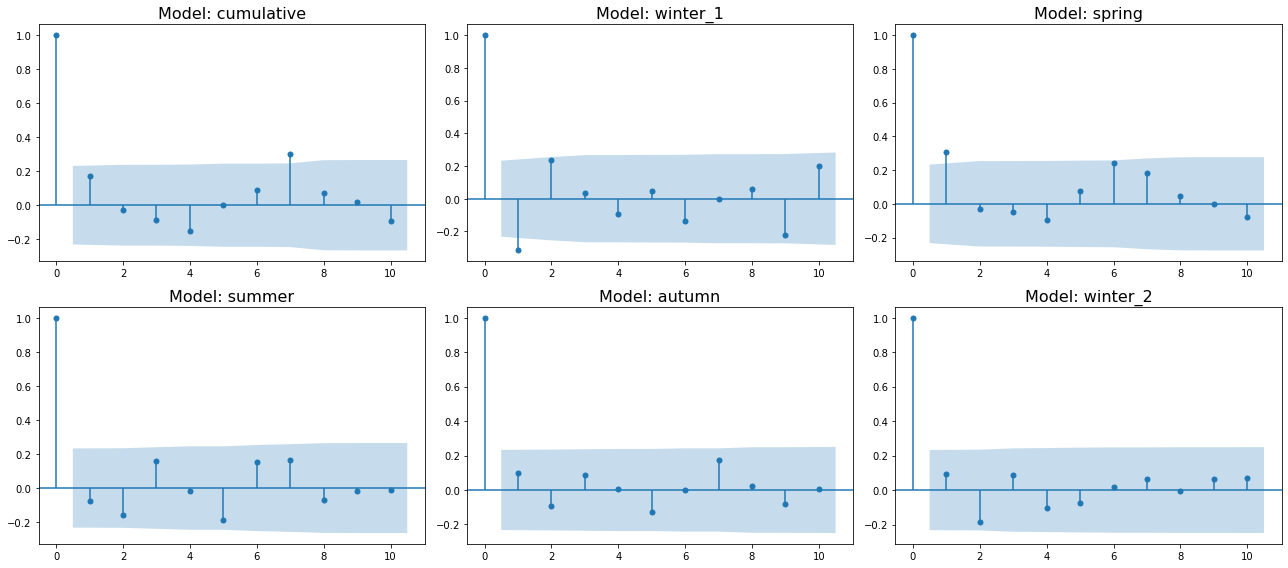

In [289]:
fig, axs = plt.subplots(2,3, figsize = (18,8))
ax_list = [item for sublist in axs for item in sublist]

for season, model in season_vars.items():
    ax = ax_list.pop(0)
    acf = smt.graphics.plot_acf(model.resid, lags=10 , alpha=0.05, ax=ax)
    ax.set_title(f"Model: {season}", fontsize = 16)
    
    
plt.tight_layout()
fig.savefig('autocorrelation.png')

There is no autocorrelation is the residuals

In [58]:
# Durbin Watson test
from statsmodels.stats.stattools import durbin_watson

In [238]:
durbs = {}
for season, model in season_vars.items():
    durbs[season] = durbin_watson(model.resid)

In [242]:
durbs_df = pd.DataFrame(durbs.items())
durbs_df.columns=['Model', 'Durbin-Watson statistic']

In [247]:
with open('dw_test.tex','w') as tf:
    tf.write(durbs_df.to_latex())

In [88]:
durbin_watson(results_total.resid)

1.6113160773978314

In [59]:
durbin_watson(results.resid)

2.1343740259697963

According to the sample size and number of regressors, the statistics should be in the range of 1.369 and 1.910 as presented by the DW statistical table. This means that the model is not suffering from serial correlation in the residuals.

### 6.1.5. Features and residuals are uncorrelated

In [90]:
df_newest

country  month   idv   confirmed      dead   population  \
10        Argentina   12.0  46.0   1602163.0   43018.0   44938712.0   
21        Australia   12.0  90.0     28381.0     909.0   25364307.0   
32          Austria   12.0  55.0    356351.0    6086.0    8877067.0   
43       Bangladesh   12.0  20.0    512496.0    7531.0  163046161.0   
54          Belarus   12.0  25.0    192361.0    1414.0    9466856.0   
..              ...    ...   ...         ...       ...          ...   
747  United Kingdom   12.0  89.0   2432892.0   72548.0   66834405.0   
758   United States   12.0  91.0  19346790.0  335789.0  328239523.0   
769         Uruguay   12.0  36.0     17962.0     168.0    3461734.0   
780         Vietnam   12.0  20.0      1456.0      35.0   96462106.0   
791          Zambia   12.0  35.0     20462.0     386.0   17861030.0   

     current_health_expenditure_of_gdp  gdp_per_capita_constant_2010_us  \
10                            9.124315                      9729.141574   
21                            9.205948                     57071.168295   
32                           10.396617                     50654.730148   
43                            2.274249                      1287.821425   
54                            5.925786                      6678.509065   
..                                 ...                              ...   
747                           9.631694                     43688.437455   
758                          17.061269                     55809.007792   
769                           9.296212                     14597.308096   
780                           5.532128                      2082.243694   
791                           4.470341                      1658.135434   

     population_ages_65_and_above_total  \
10                            5052508.0   
21                            4038302.0   
32                            1693354.0   
43                            8446364.0   
54                            1439042.0   
..                                  ...   
747                          12370177.0   
758                          53206334.0   
769                            517226.0   
780                           7286432.0   
791                            377817.0   

     population_density_people_per_sq_km_of_land_area  ...  \
10                                          16.258510  ...   
21                                           3.247871  ...   
32                                         107.127967  ...   
43                                        1239.579312  ...   
54                                          46.719504  ...   
..                                                ...  ...   
747                                        274.708982  ...   
758                                         35.713622  ...   
769                                         19.708028  ...   
780                                        308.125246  ...   
791                                         23.341479  ...   

     containment_health_index  democracy_index          capital      distance  \
10                  73.400000             70.2     Buenos Aires  19206.559549   
21                  60.961935             90.9         Canberra   8153.589761   
32                  72.941579             82.9           Vienna   8081.565310   
43                  72.120000             58.8            Dhaka   2477.356735   
54                  36.265714             24.8            Minsk   7119.018739   
..                        ...              ...              ...           ...   
747                 66.425556             85.2           London   8894.845144   
758                 63.078571             79.6  Washington D.C.  12222.325032   
769                 53.426552             83.8       Montevideo  19011.570501   
780                 56.821429             30.8            Hanoi   1355.430475   
791                 53.677391             50.9           Lusaka  10501.353873   

     continent  confirm

In [413]:
from scipy.stats.stats import pearsonr
corr_error = {}
for column in vars_to_use:
    if not isinstance(df_newest[column].iloc[0], str):
        corr_test = pearsonr(df_newest[column], results_total.resid)
        corr_error[column] = {'correlation': corr_test[0].round(4), 'p-value': corr_test[1].round(4)}
        print(f'Variable: {column} --- correlation: {corr_test[0]:.4f}, p-value: {corr_test[1]:.4f}')

Variable: individualism_index --- correlation: -0.0000, p-value: 1.0000
Variable: gdp_per_capita --- correlation: -0.0000, p-value: 1.0000
Variable: population_density --- correlation: -0.0000, p-value: 1.0000
Variable: mobility_index --- correlation: 0.0115, p-value: 0.9235
Variable: containment_health_index --- correlation: 0.0567, p-value: 0.6363
Variable: democracy_index --- correlation: -0.0000, p-value: 1.0000
Variable: distance_log --- correlation: -0.0000, p-value: 1.0000
Variable: cases_neighbors --- correlation: 0.0000, p-value: 1.0000


In [429]:
vars_to_use = ['individualism_index', 'gdp_per_capita', 
               'population_density', 
               'mobility_index', 'containment_health_index', 'democracy_index', 'distance_log', 
              'cases_neighbors']

In [456]:
corr_error = {}

for season, model in season_vars.items():
    corr_error[season] = {}
    
for season, model in season_vars.items():
    for column in vars_to_use:
        if season == 'cumulative': df_ = df_newest2[vars_to_use].copy()
        else: df_ = df_seasons2.loc[df_seasons2.season == season, vars_to_use].copy()
        if not isinstance(df_[column].iloc[0], str):
            corr_test = pearsonr(df_[column], model.resid)
            corr_error[season][column] = corr_test[0].round(4)

In [458]:
corr_error = pd.DataFrame(corr_error)

In [459]:
with open('corr_error.tex','w') as tf:
    tf.write(corr_error.to_latex())

There is no relationship between any of the predictors and the error term.

### 6.1.6. Outliers

In [ ]:
fitted_vals = results_total.predict()
resids = results_total.resid
y = df_newest['confirmed_log']

In [116]:
df_newest[df_newest.index == 780]

country  month   idv  confirmed  dead  population  \
780  Vietnam   12.0  20.0     1456.0  35.0  96462106.0   

     current_health_expenditure_of_gdp  gdp_per_capita_constant_2010_us  \
780                           5.532128                      2082.243694   

     population_ages_65_and_above_total  \
780                           7286432.0   

     population_density_people_per_sq_km_of_land_area  ...  \
780                                        308.125246  ...   

     containment_health_index  democracy_index  capital     distance  \
780                 56.821429             30.8    Hanoi  1355.430475   

     continent  confirmed_log  current_health_expenditure_of_gdp_log  \
780         AS       7.283448                               1.710573   

     distance_log  gdp_per_capita_constant_2010_us_log    season  
780      7.211874                             7.641201  winter_2  

[1 rows x 29 columns]

In [118]:
results_total2 = smf.ols('confirmed_log ~ ' + ' + '.join(vars_to_use), data = df_newest[df_newest.country != 'Vietnam']).fit()

In [119]:
results_total2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          confirmed_log   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     6.119
Date:                Sun, 03 Jan 2021   Prob (F-statistic):           4.34e-06
Time:                        14:17:02   Log-Likelihood:                -125.63
No. Observations:                  71   AIC:                             271.3
Df Residuals:                      61   BIC:                             293.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            9.7351      3.794      2.566      0.013       2.149      17.322
idv                                                  0.0194      0.012      1.578      0.120      -0.005       0.044
current_health_expenditure_of_gdp                    0.3192      0.111      2.869      0.006       0.097       0.542
gdp_per_capita_constant_2010_us                  -1.751e-05   1.23e-05     -1.424      0.160   -4.21e-05    7.09e-06
over65_per_capita                                   -2.4652      4.478     -0.550      0.584     -11.420       6.490
population_density_people_per_sq_km_of_land_area -6.924e-05      0.000     -0.324      0.747      -0.000       0.000
mobility_index                                       0.0020      0.022      0.092      0.927      -0.042       0.046
containment_health_index                             0.1059      0.020      5.413      0.000       0.067       0.145
democracy_index                                     -0.0412      0.015     -2.668      0.010      -0.072      -0.010
distance_log                                        -0.3605      0.410     -0.879      0.383      -1.180       0.459
==============================================================================
Omnibus:                        1.090   Durbin-Watson:                   1.681
Prob(Omnibus):                  0.580   Jarque-Bera (JB):                0.795
Skew:                          -0.259   Prob(JB):                        0.672
Kurtosis:                       3.028   Cond. No.                     9.20e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [123]:
results_total.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          confirmed_log   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     4.767
Date:                Sun, 03 Jan 2021   Prob (F-statistic):           7.78e-05
Time:                        14:18:00   Log-Likelihood:                -134.24
No. Observations:                  72   AIC:                             288.5
Df Residuals:                      62   BIC:                             311.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            3.8786      3.791      1.023      0.310      -3.699      11.456
idv                                                  0.0200      0.013      1.484      0.143      -0.007       0.047
current_health_expenditure_of_gdp                    0.2310      0.119      1.935      0.058      -0.008       0.470
gdp_per_capita_constant_2010_us                  -1.678e-05   1.35e-05     -1.242      0.219   -4.38e-05    1.02e-05
over65_per_capita                                   -0.4140      4.882     -0.085      0.933     -10.173       9.345
population_density_people_per_sq_km_of_land_area -1.116e-05      0.000     -0.048      0.962      -0.000       0.000
mobility_index                                       0.0078      0.024      0.325      0.747      -0.040       0.056
containment_health_index                             0.1071      0.021      4.986      0.000       0.064       0.150
democracy_index                                     -0.0316      0.017     -1.887      0.064      -0.065       0.002
distance_log                                         0.2459      0.413      0.595      0.554      -0.580       1.072
==============================================================================
Omnibus:                        6.645   Durbin-Watson:                   1.531
Prob(Omnibus):                  0.036   Jarque-Bera (JB):                5.971
Skew:                          -0.578   Prob(JB):                       0.0505
Kurtosis:                       3.810   Cond. No.                     8.89e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.89e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

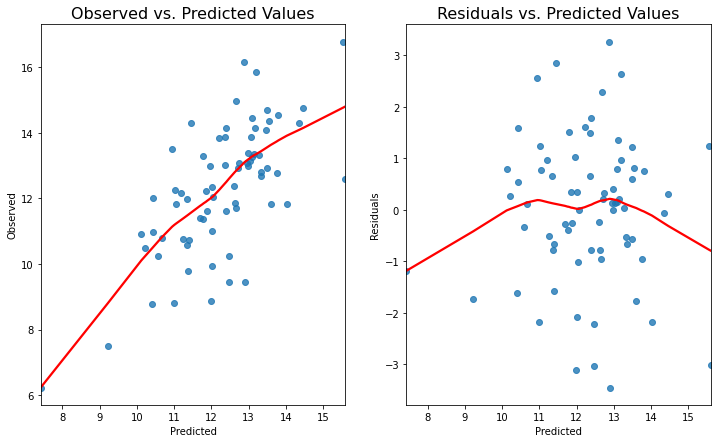

In [126]:
get_plot(results_total2, df_newest[df_newest.country != 'Vietnam'])

Results do not change after checking for outliers

### 6.1.7. High leverage points

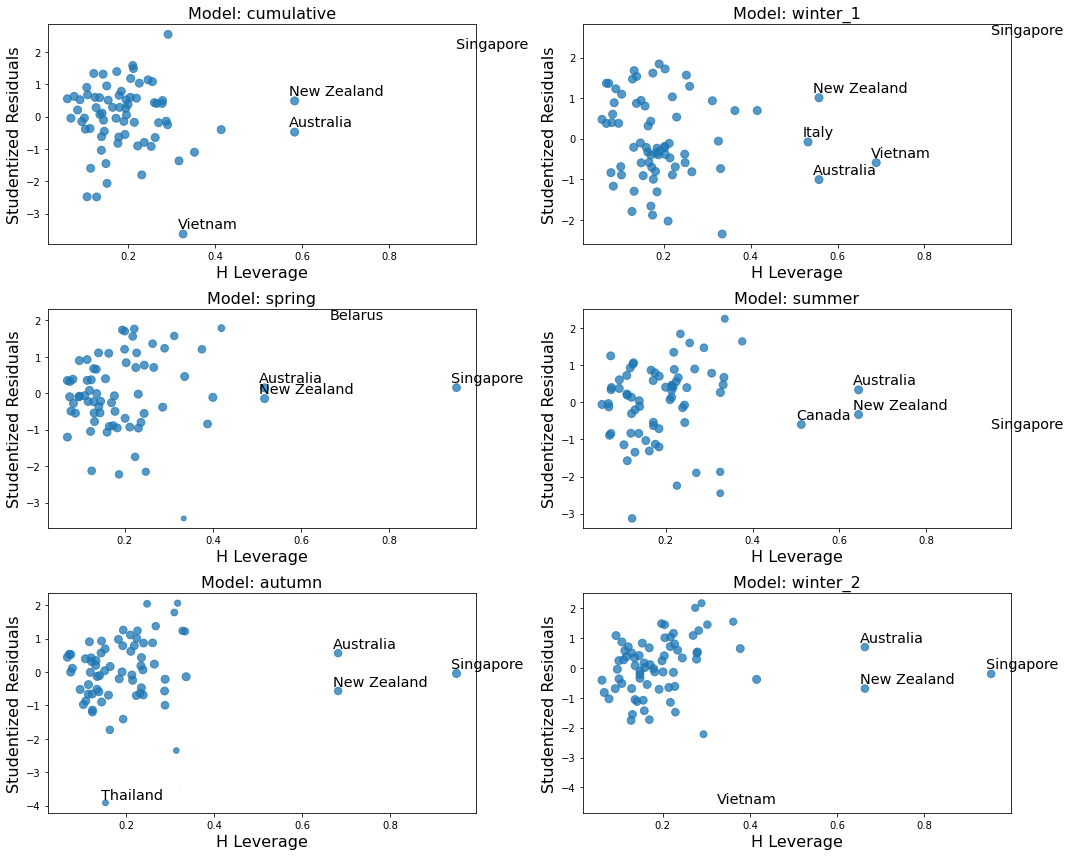

In [298]:
fig, axs = plt.subplots(3,2, figsize = (15,12))
ax_list = [item for sublist in axs for item in sublist]

for season, model in season_vars.items():
    ax = ax_list.pop(0)
    sm.graphics.influence_plot(model, criterion = 'cooks', ax=ax, size = 0.1, alpha = 0.001)
    ax.set_title(f"Model: {season}", fontsize = 16)
    
    
plt.tight_layout()
fig.savefig('leverage.png')

In [137]:
results_total3 = smf.ols('confirmed_log ~ ' + ' + '.join(vars_to_use), data = df_newest[df_newest.country != 'Singapore']).fit()

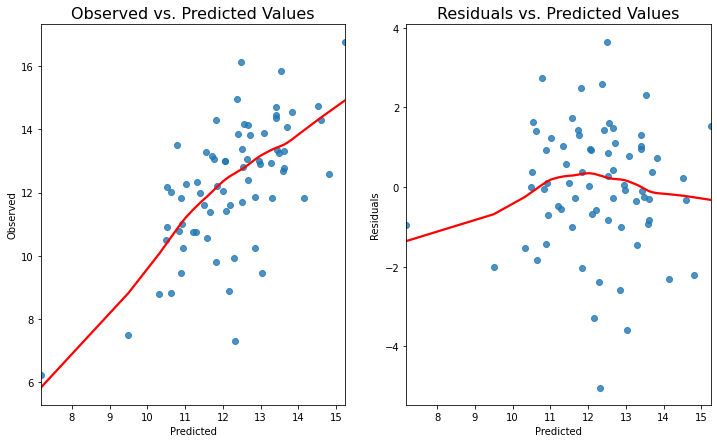

In [139]:
get_plot(results_total3, df_newest[df_newest.country != 'Singapore'])

In [140]:
results_total3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          confirmed_log   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     5.009
Date:                Sun, 03 Jan 2021   Prob (F-statistic):           4.72e-05
Time:                        14:26:54   Log-Likelihood:                -131.72
No. Observations:                  71   AIC:                             283.4
Df Residuals:                      61   BIC:                             306.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            4.9336      3.832      1.287      0.203      -2.730      12.597
idv                                                  0.0196      0.013      1.466      0.148      -0.007       0.046
current_health_expenditure_of_gdp                    0.2373      0.118      2.002      0.050       0.000       0.474
gdp_per_capita_constant_2010_us                  -1.985e-05   1.36e-05     -1.463      0.149    -4.7e-05    7.29e-06
over65_per_capita                                   -0.2135      4.844     -0.044      0.965      -9.900       9.473
population_density_people_per_sq_km_of_land_area    -0.0013      0.001     -1.391      0.169      -0.003       0.001
mobility_index                                       0.0169      0.025      0.688      0.494      -0.032       0.066
containment_health_index                             0.1160      0.022      5.224      0.000       0.072       0.160
democracy_index                                     -0.0278      0.017     -1.656      0.103      -0.061       0.006
distance_log                                         0.0842      0.425      0.198      0.844      -0.766       0.934
==============================================================================
Omnibus:                        5.912   Durbin-Watson:                   1.469
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                5.131
Skew:                          -0.542   Prob(JB):                       0.0769
Kurtosis:                       3.746   Cond. No.                     8.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Singapore, the point with high leverage, does not change any of the conclusions reached

### 6.1.8. Normality of residuals

In [98]:
from scipy import stats

def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')
    print('If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. ')


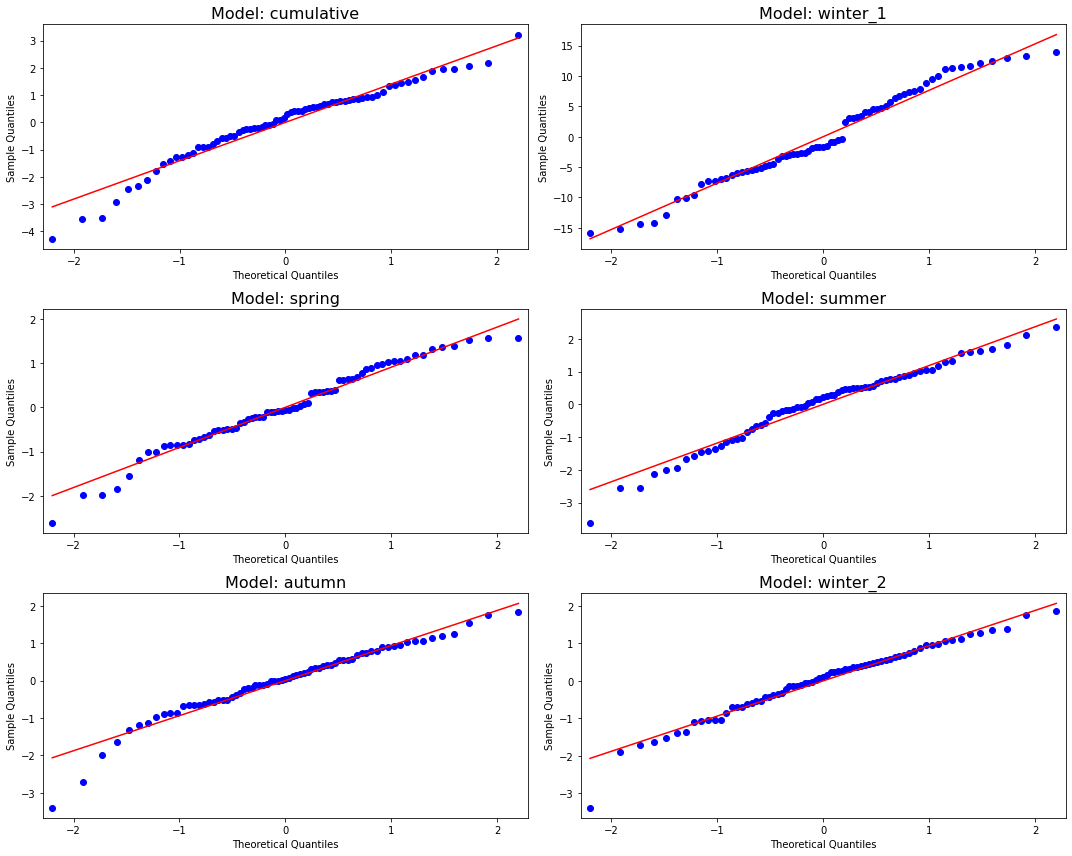

In [301]:
fig, axs = plt.subplots(3,2, figsize = (15,12))
ax_list = [item for sublist in axs for item in sublist]

for season, model in season_vars.items():
    ax = ax_list.pop(0)
    sm.ProbPlot(model.resid).qqplot(line='s', ax=ax);
    ax.set_title(f"Model: {season}", fontsize = 16)
    
    
plt.tight_layout()
fig.savefig('normality_tests.png')

In [ ]:
fig, axs = plt.subplots(3,2, figsize = (15,12))
ax_list = [item for sublist in axs for item in sublist]

for season, model in season_vars.items():
    ax = ax_list.pop(0)
    sm.ProbPlot(model.resid).qqplot(line='s', ax=ax);
    ax.set_title(f"Model: {season}", fontsize = 16)
    
    
plt.tight_layout()
fig.savefig('normality_tests.png')

In [314]:
tests = {}
for season, model in season_vars.items():

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    tests[season] = {'Jarque-Bera test': jb[1],
                     'Shapiro-Wilk test': sw[1],
                     'Kolmogorov-Smirnov test': ks.pvalue}

In [319]:
tests = pd.DataFrame(tests).round(4)

In [321]:
with open('tests_norm.tex','w') as tf:
    tf.write(tests.to_latex())

Jarque-Bera test ---- statistic: 22.2804, p-value: 1.4517044101491905e-05
Shapiro-Wilk test ---- statistic: 0.9489, p-value: 0.0055
Kolmogorov-Smirnov test ---- statistic: 0.1108, p-value: 0.3161
Anderson-Darling test ---- statistic: 0.8127, 5% critical value: 0.7490
If the returned AD statistic is larger than the critical value, then for the 5% significance level, the null hypothesis that the data come from the Normal distribution should be rejected. 


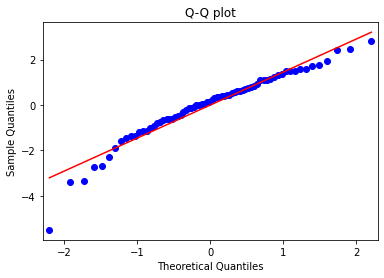

In [99]:
normality_of_residuals_test(results_total)

# 7. Additional checks

## 7.1. Sensitivity check

In [12]:
def y_model(ind, cont):
    return 10 + 0.048 * ind + 0.211 * cont - 0.001* (ind*cont)

In [13]:
y_model(10, 30)

16.51

In [10]:
for cont in [20,50,80]:
    print()
    print()
    print(f"------- CONT: {cont}----------------------")
    for ind in range(5,100,5):
        print(f"Individualism: {ind}, Results: {y_model(ind, cont)}")



------- CONT: 20----------------------
Individualism: 5, Results: 14.360000000000001
Individualism: 10, Results: 14.5
Individualism: 15, Results: 14.64
Individualism: 20, Results: 14.78
Individualism: 25, Results: 14.919999999999998
Individualism: 30, Results: 15.06
Individualism: 35, Results: 15.2
Individualism: 40, Results: 15.34
Individualism: 45, Results: 15.479999999999999
Individualism: 50, Results: 15.620000000000001
Individualism: 55, Results: 15.76
Individualism: 60, Results: 15.899999999999999
Individualism: 65, Results: 16.04
Individualism: 70, Results: 16.18
Individualism: 75, Results: 16.32
Individualism: 80, Results: 16.459999999999997
Individualism: 85, Results: 16.6
Individualism: 90, Results: 16.74
Individualism: 95, Results: 16.880000000000003


------- CONT: 50----------------------
Individualism: 5, Results: 20.54
Individualism: 10, Results: 20.53
Individualism: 15, Results: 20.52
Individualism: 20, Results: 20.509999999999998
Individualism: 25, Results: 20.5
Indi

## 7.2. Check on average government intervention

In [16]:
df = pd.read_csv('2021-01-04 final_data.csv')
df = df[df.country != 'Tanzania']

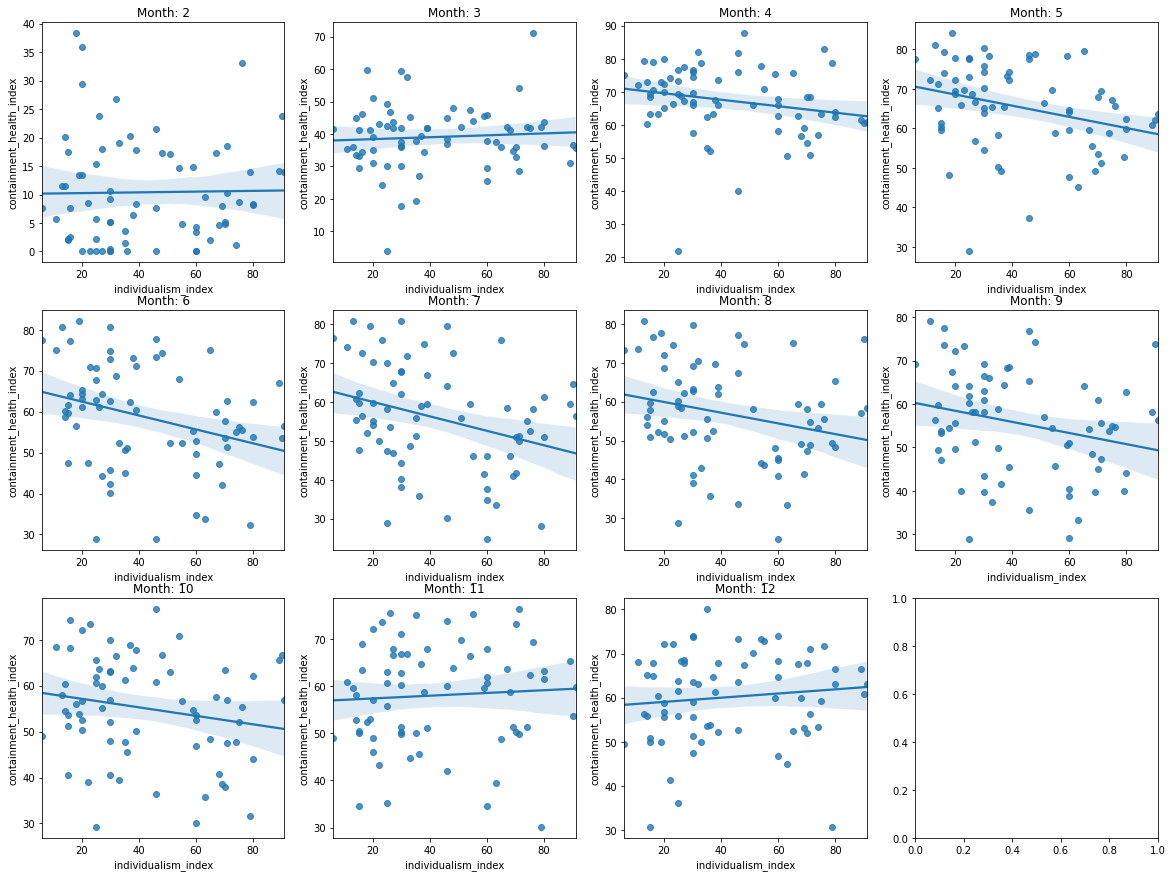

In [25]:
fig, axs = plt.subplots(3,4, figsize = (20,15))

ax_list = [item for sublist in axs for item in sublist]
for month in range(2,13):
    ax = ax_list.pop(0)
    
    df_ = df[df.month == month]
    sns.regplot(x = 'individualism_index', y = 'containment_health_index', data = df_, ax=ax)
    ax.set_title(f"Month: {month}")

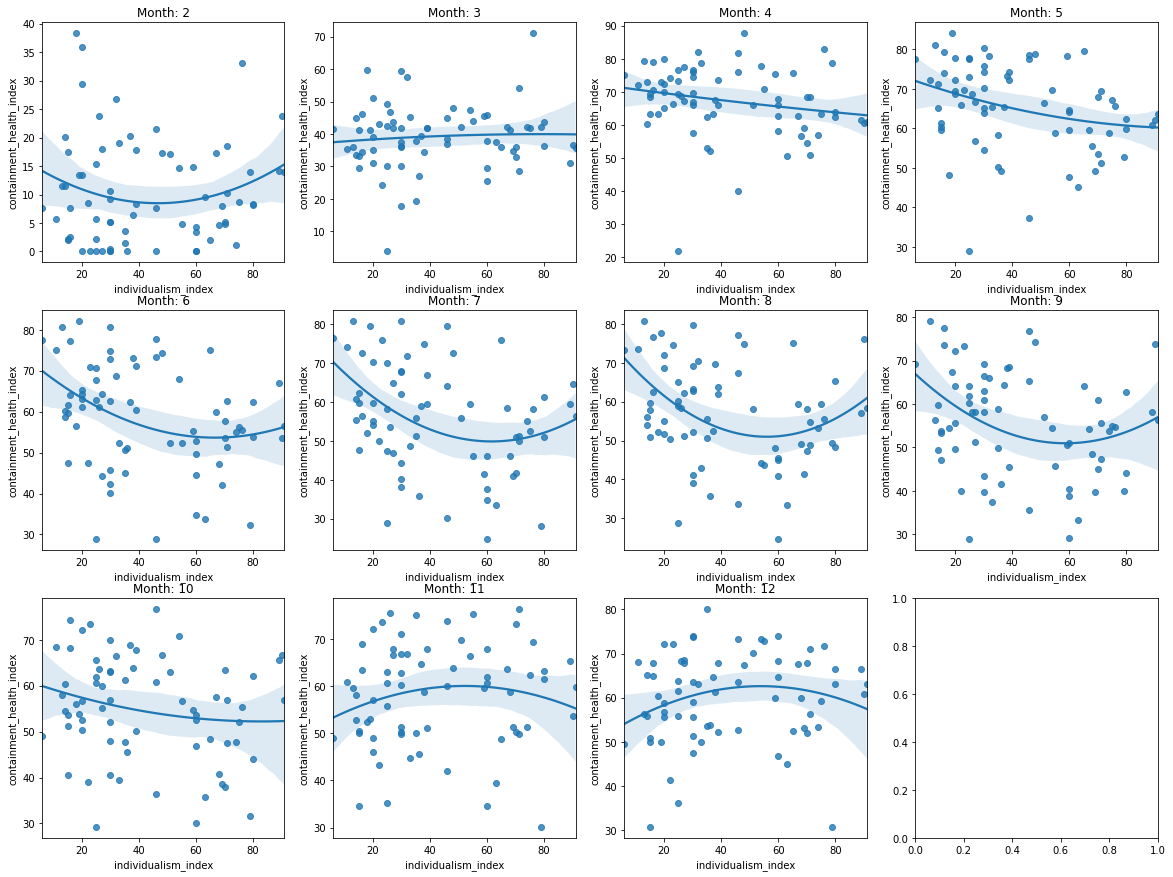

In [28]:
fig, axs = plt.subplots(3,4, figsize = (20,15))

ax_list = [item for sublist in axs for item in sublist]
for month in range(2,13):
    ax = ax_list.pop(0)
    
    df_ = df[df.month == month]
    sns.regplot(x = 'individualism_index', y = 'containment_health_index', data = df_, ax=ax, order = 2)
    ax.set_title(f"Month: {month}")

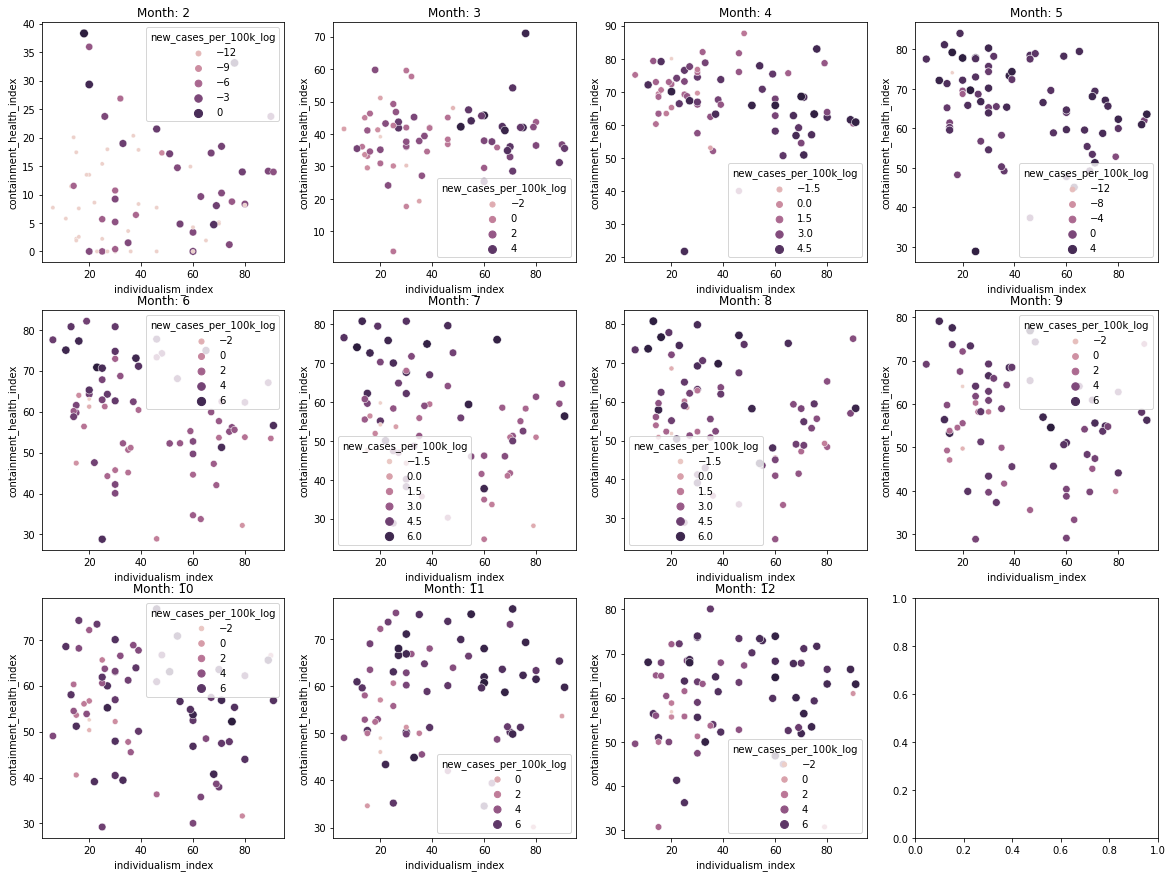

In [31]:
fig, axs = plt.subplots(3,4, figsize = (20,15))

ax_list = [item for sublist in axs for item in sublist]
for month in range(2,13):
    ax = ax_list.pop(0)
    
    df_ = df[df.month == month]
    sns.scatterplot(x = 'individualism_index', y = 'containment_health_index',
                    hue = 'new_cases_per_100k_log',
                    size ='new_cases_per_100k_log',
                    data = df_, ax=ax)
    ax.set_title(f"Month: {month}")

In [33]:
df_newest = df[df.month==12]

In [34]:
df_newest = df_newest.set_index('country')

In [35]:
df_newest['mobility_index_avg'] = df.groupby('country').mobility_index.mean()
df_newest['containment_health_index_avg'] = df.groupby('country').containment_health_index.mean()

In [36]:
df_newest = get_interactions(df_newest, month_12=True)

In [40]:
df_newest['confirmed_per_100k'] = (df_newest['confirmed'] / df_newest['population'] ) * 100_000
df_newest['confirmed_per_100k_log'] = np.log(df_newest['confirmed_per_100k'])

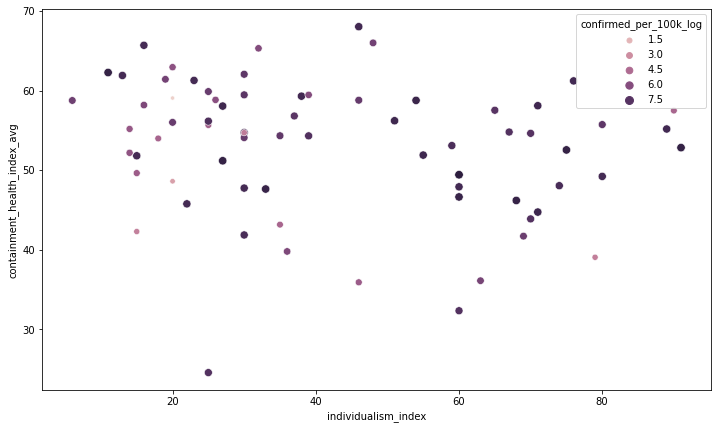

In [42]:
fig, ax = plt.subplots(figsize=(12,7))

sns.scatterplot(x = 'individualism_index', y = 'containment_health_index_avg',
                hue = 'confirmed_per_100k_log',
                size ='confirmed_per_100k_log',
                data = df_newest, ax=ax);

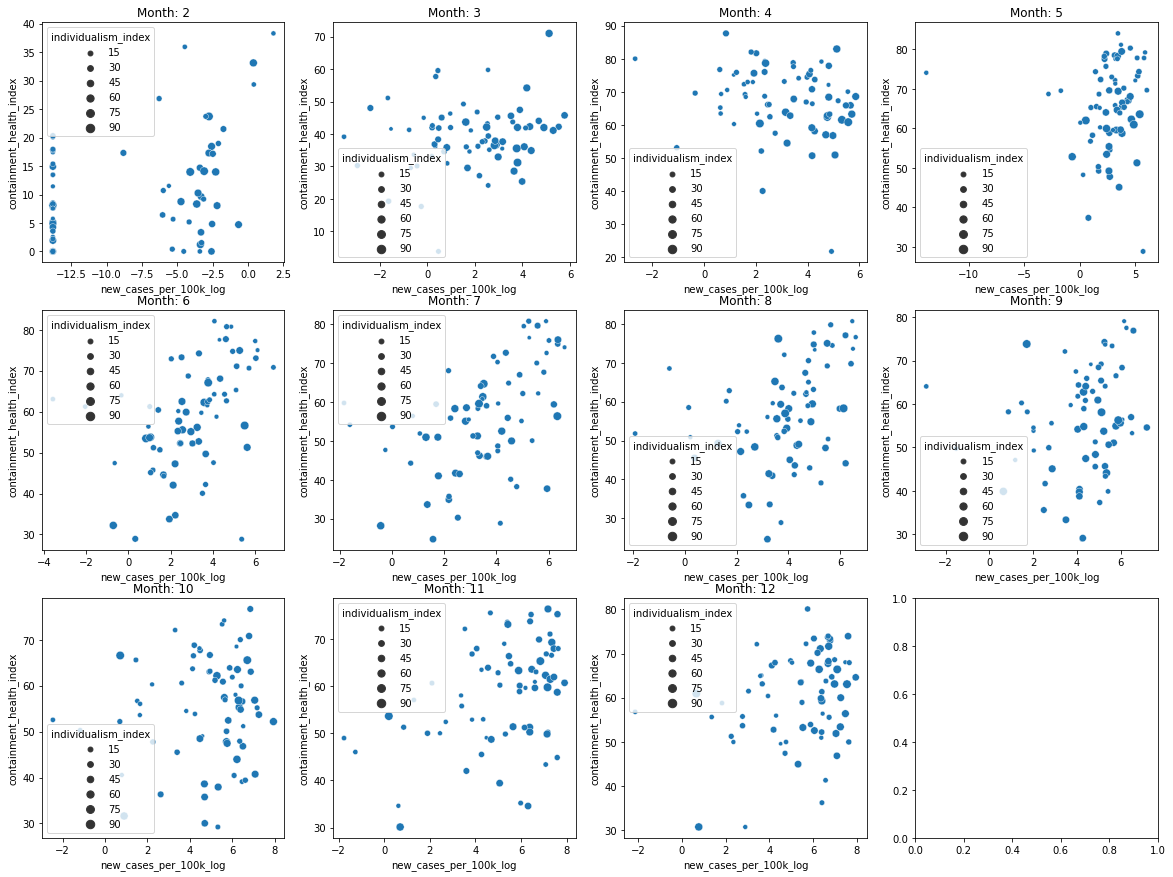

In [48]:
fig, axs = plt.subplots(3,4, figsize = (20,15))

ax_list = [item for sublist in axs for item in sublist]
for month in range(2,13):
    ax = ax_list.pop(0)
    
    df_ = df[df.month == month]
    sns.scatterplot(x = 'new_cases_per_100k_log', y = 'containment_health_index',
                    size ='individualism_index',
                    data = df_, ax=ax)
    ax.set_title(f"Month: {month}")

<AxesSubplot:xlabel='individualism_index', ylabel='containment_health_index_avg'>

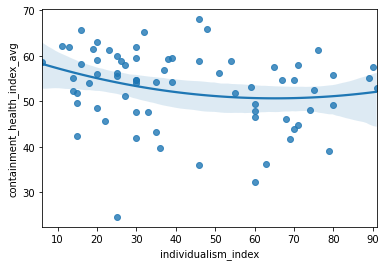

In [47]:
sns.regplot(x = 'individualism_index', y = 'containment_health_index_avg', data = df_newest, order = 2)

## 7.3. MCAR test

In [49]:
import scipy.stats as st

def checks_input_mcar_tests(data):
    """ Checks whether the input parameter of class McarTests is correct
            Parameters
            ----------
            data:
                The input of McarTests specified as 'data'
            Returns
            -------
            bool
                True if input is correct
            """

    if not isinstance(data, pd.DataFrame):
        print("Error: Data should be a Pandas DataFrame")
        return False

    if not any(data.dtypes.values == np.float):
        if not any(data.dtypes.values == np.int):
            print("Error: Dataset cannot contain other value types than floats and/or integers")
            return False

    if not data.isnull().values.any():
        print("Error: No NaN's in given data")
        return False

    return True

class McarTests():

    def __init__(self, data):
        self.data = data

    def mcar_test(self):
        """ Implementation of Little's MCAR test
        Parameters
        ----------
        data: Pandas DataFrame
            An incomplete dataset with samples as index and variables as columns
        Returns
        -------
        p_value: Float
            This value is the outcome of a chi-square statistical test, testing whether the null hypothesis
            'the missingness mechanism of the incomplete dataset is MCAR' can be rejected.
        """

        if not checks_input_mcar_tests(self.data):
            raise Exception("Input not correct")

        dataset = self.data.copy()
        vars = dataset.dtypes.index.values
        n_var = dataset.shape[1]

        # mean and covariance estimates
        # ideally, this is done with a maximum likelihood estimator
        gmean = dataset.mean()
        gcov = dataset.cov()

        # set up missing data patterns
        r = 1 * dataset.isnull()
        mdp = np.dot(r, list(map(lambda x: ma.pow(2, x), range(n_var))))
        sorted_mdp = sorted(np.unique(mdp))
        n_pat = len(sorted_mdp)
        correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
        dataset['mdp'] = pd.Series(correct_mdp, index=dataset.index)

        # calculate statistic and df
        pj = 0
        d2 = 0
        for i in range(n_pat):
            dataset_temp = dataset.loc[dataset['mdp'] == i, vars]
            select_vars = ~dataset_temp.isnull().any()
            pj += np.sum(select_vars)
            select_vars = vars[select_vars]
            means = dataset_temp[select_vars].mean() - gmean[select_vars]
            select_cov = gcov.loc[select_vars, select_vars]
            mj = len(dataset_temp)
            parta = np.dot(means.T, np.linalg.solve(select_cov, np.identity(select_cov.shape[1])))
            d2 += mj * (np.dot(parta, means))

        df = pj - n_var

        # perform test and save output
        p_value = 1 - st.chi2.cdf(d2, df)

        return p_value

    def mcar_t_tests(self):
        """ MCAR tests for each pair of variables
        Parameters
        ----------
        data: Pandas DataFrame
            An incomplete dataset with samples as index and variables as columns
        Returns
        -------
        mcar_matrix: Pandas DataFrame
            A square Pandas DataFrame containing True/False for each pair of variables
            True: Missingness in index variable is MCAR for column variable
            False: Missingness in index variable is not MCAR for column variable
        """

        if not checks_input_mcar_tests(self.data):
            raise Exception("Input not correct")

        dataset = self.data.copy()
        vars = dataset.dtypes.index.values
        mcar_matrix = pd.DataFrame(data=np.zeros(shape=(dataset.shape[1], dataset.shape[1])),
                                   columns=vars, index=vars)

        for var in vars:
            for tvar in vars:
                part_one = dataset.loc[dataset[var].isnull(), tvar].dropna()
                part_two = dataset.loc[~dataset[var].isnull(), tvar].dropna()
                mcar_matrix.loc[var, tvar] = st.ttest_ind(part_one, part_two, equal_var=False).pvalue

        mcar_matrix = mcar_matrix[mcar_matrix.notnull()] > 0.05

        return mcar_matrix

In [50]:
checks_input_mcar_tests(df)

Error: No NaN's in given data


False

## 7.4. GDP calculations

In [52]:
df['gdp'] = df['gdp_per_capita'] * df['population']

In [56]:
with open('corr_coef_gdp.tex','w') as tf:
    tf.write(df[df.month == 12][['gdp', 'gdp_per_capita', 'individualism_index']].corr().to_latex())


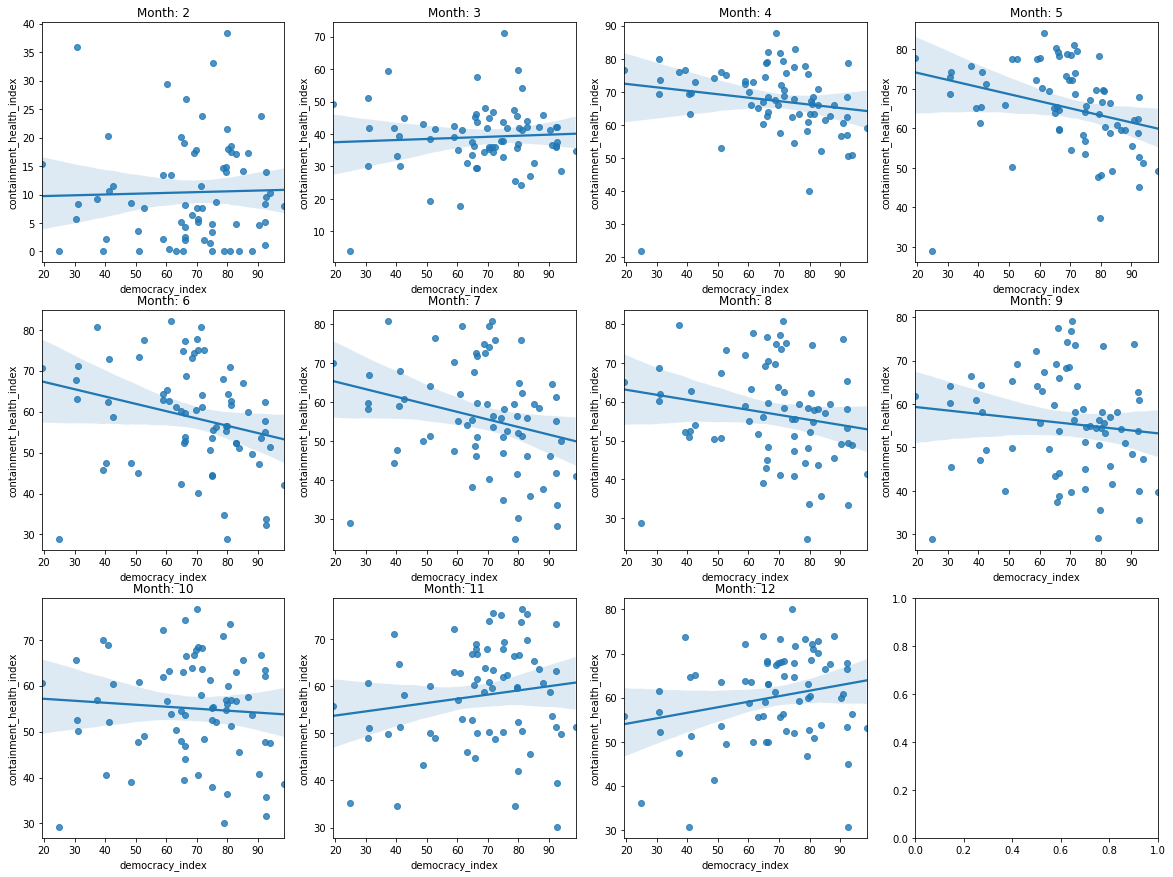

In [63]:
fig, axs = plt.subplots(3,4, figsize = (20,15))

ax_list = [item for sublist in axs for item in sublist]
for month in range(2,13):
    ax = ax_list.pop(0)
    
    df_ = df[df.month == month]
    sns.regplot(x = 'democracy_index', y = 'containment_health_index', data = df_, ax=ax)
    ax.set_title(f"Month: {month}")

In [74]:
df4 = df.groupby(['country']).agg({'containment_health_index': ['std'], 
                             'democracy_index': 'mean'})

<AxesSubplot:xlabel='mean', ylabel='std'>

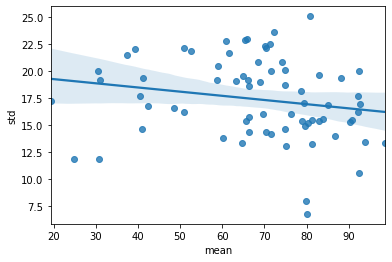

In [81]:
sns.regplot(x = 'democracy_index', y = 'containment_health_index', data = df4)

## 7.5. Stringency 

In [8]:
df['individualism_index'].mean()

42.309859154929576

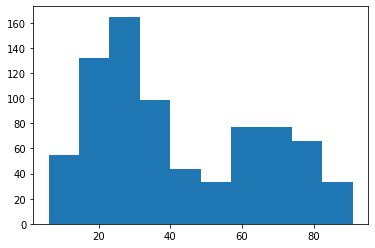

In [9]:
plt.hist(df['individualism_index']);

In [58]:
df['ind_category'] = df['individualism_index'].map(lambda x: 'high' if x >= 60 else 'low' if x <= 25 else 'medium')

In [11]:
df['ind_category'].value_counts() / 11

medium    27.0
low       22.0
high      22.0
Name: ind_category, dtype: float64

In [12]:
dfn = df[df.month == 12].copy()

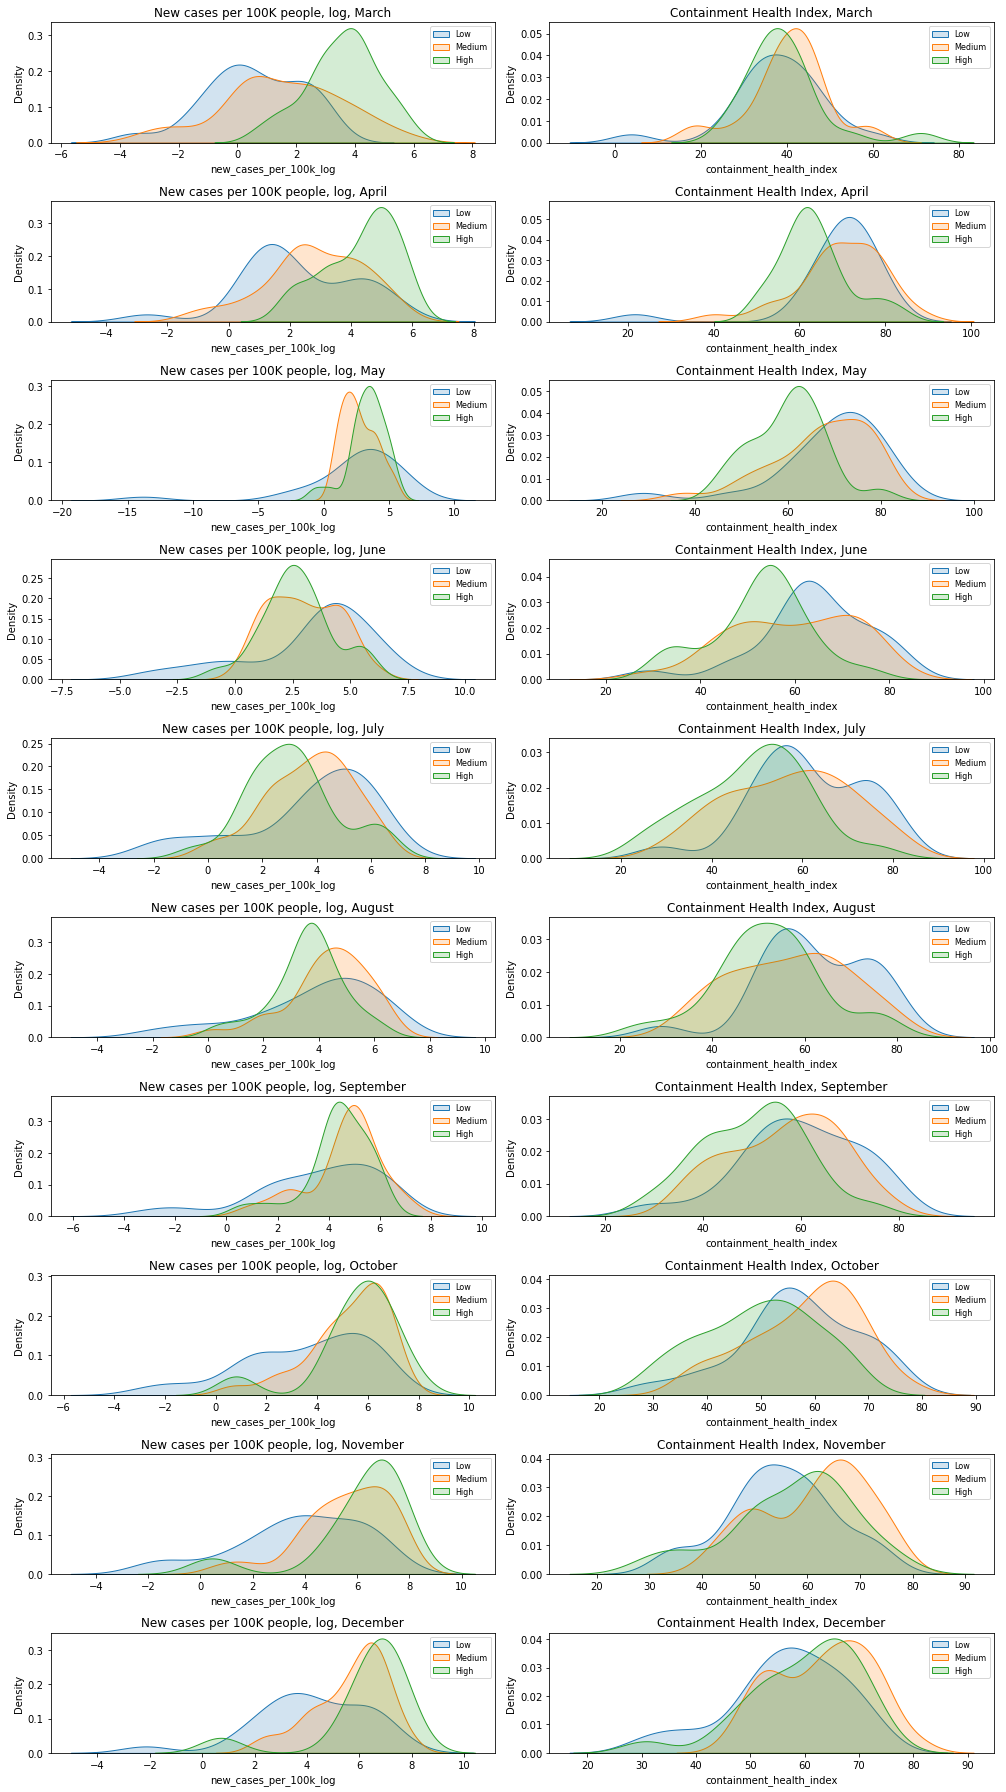

In [14]:
fig, axs = plt.subplots(10,2,figsize=(14,25))

graph_titles = {'new_cases_per_100k_log': 'New cases per 100K people, log',
                'containment_health_index': 'Containment Health Index'}

for i in range(10):
    for k, var in enumerate(['new_cases_per_100k_log', 'containment_health_index']):
        month = int(i+3)
        dfnt = df[df.month == month].copy()
        sns.kdeplot(dfnt.loc[dfnt.ind_category == 'low', var], fill=True, label = 'Low', bw_adjust = .8, alpha = 0.2, ax=axs[i,k])
        sns.kdeplot(dfnt.loc[dfnt.ind_category == 'medium', var], fill=True, label = 'Medium', bw_adjust = .8, alpha = 0.2, ax=axs[i,k])
        sns.kdeplot(dfnt.loc[dfnt.ind_category == 'high', var], fill=True, label = 'High', bw_adjust = .8, alpha = 0.2, ax=axs[i,k])
        axs[i,k].set_title(f"{graph_titles[var]}, {calendar.month_name[month]}")
        axs[i,k].legend(prop={'size': 8})
  
plt.tight_layout()
fig.savefig('cases_health_dist.png')

## 7.6. Differences in COVID-19 rates and response

In [ ]:
import altair as alt

In [42]:
df = pd.read_csv('2021-01-04 final_data.csv')
df = df[df.country != 'Tanzania'].copy()

In [134]:
df = df[df.country != 'Trinidad and Tobago'].copy()

In [138]:
df['individualism category'] = df['individualism_index'].map(lambda x: 'high' if x >= 60 else 'low' if x <= 25 else 'medium')

In [152]:
color_by_variable = alt.Chart(df[df.month != 2]).mark_circle(opacity=0.3).encode(
    x=alt.X('new_cases_per_100k_log:Q', axis = alt.Axis(title = 'New cases per 100 thousand people (log)')),
    y=alt.Y('containment_health_index', axis = alt.Axis(title = 'Containment health index')),
    color=alt.Color('individualism category', 
                    sort = ['low', 'medium', 'high']))

In [154]:
color_by_variable.properties(
) + color_by_variable.transform_regression('new_cases_per_100k_log', 'containment_health_index', 
        groupby=['individualism category']).mark_line(size=3, opacity = 0.9)

alt.LayerChart(...)